This Jupyter notebook shows performance of NO methods for the deployment of reactors based on the demand of power and sources, storage facilities, and sinks of fuel to support the deployment of reactors.

# Performance tests: Case 6

Flow: Source -(sourceout)-> Reactor -(reactorout)-> Storage -(coolout)-> Sink

The driving commodity is 'power' with a demand equation of 1000*t*.

This time the facilities 'storage' and 'sink' are supply driven deployed.

The next cell produces .xml input file of Cyclus, its respective .sqlite output, and post processing data of that output file used in the following cells.

In [1]:
import json
import re
import subprocess
import os
import sqlite3 as lite
import copy
import glob
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import d3ploy.tester as tester
import d3ploy.plotter as plotter
import collections

# Delete previously generated files
direc = os.listdir('./')
hit_list = glob.glob('*.sqlite') + glob.glob('*.xml') + glob.glob('*.png') + glob.glob('*.csv') + glob.glob('*.txt')
for file in hit_list:
    os.remove(file)

ENV = dict(os.environ)
ENV['PYTHONPATH'] = ".:" + ENV.get('PYTHONPATH', '')

calc_methods = ["ma", "arma", "arch", "poly", "exp_smoothing", "holt_winters", "fft"]

demand_eq = "1000*t"

control = """
<control>
    <duration>100</duration>
    <startmonth>1</startmonth>
    <startyear>2000</startyear>
</control>"""

archetypes = """
<archetypes>
        <spec>
            <lib>cycamore</lib>
            <name>Source</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Reactor</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Storage</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>Sink</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullRegion</name>
        </spec>
        <spec>
            <lib>agents</lib>
            <name>NullInst</name>
        </spec>
        <spec>
            <lib>cycamore</lib>
            <name>DeployInst</name>
        </spec>
        <spec>
            <lib>d3ploy.demand_driven_deployment_inst</lib>
            <name>DemandDrivenDeploymentInst</name>
        </spec>
        <spec>
            <lib>d3ploy.supply_driven_deployment_inst</lib>
            <name>SupplyDrivenDeploymentInst</name>
        </spec>
    </archetypes>
"""

source = """
<facility>
    <name>source</name>
    <config>
        <Source>
            <outcommod>sourceout</outcommod>
            <outrecipe>sourceoutrecipe</outrecipe>
            <throughput>3000</throughput>
        </Source>
    </config>
</facility>
"""

reactor = """
<facility>
    <name>reactor</name>
    <config>
      <Reactor>
        <fuel_inrecipes>
            <val>sourceoutrecipe</val>
        </fuel_inrecipes>
        <fuel_outrecipes>
            <val>reactoroutrecipe</val>
        </fuel_outrecipes>
        <fuel_incommods>
            <val>sourceout</val>
        </fuel_incommods>
        <fuel_outcommods>
            <val>reactorout</val>
        </fuel_outcommods>
        <cycle_time>1</cycle_time>
        <refuel_time>0</refuel_time>
        <assem_size>1000</assem_size>
        <n_assem_core>3</n_assem_core>
        <n_assem_batch>1</n_assem_batch>
        <power_cap>1000</power_cap>
      </Reactor>
    </config>
</facility>
"""

storage="""
    <facility>
        <name>storage</name>
        <config>
            <Storage>
                <in_commods>
                    <val>reactorout</val>
                </in_commods>
                <residence_time>3</residence_time>
                <out_commods>
                    <val>coolout</val>
                </out_commods>
                <max_inv_size>1e6</max_inv_size>
            </Storage>
        </config>
    </facility>
"""

sink = """
<facility>
        <name>sink</name>
        <config>
            <Sink>
                <in_commods>
                    <val>coolout</val>
                </in_commods>
                <max_inv_size>1e6</max_inv_size>
            </Sink>
        </config>
    </facility>
"""

region = {}
for calc_method in calc_methods:
    region[calc_method] = """
    <region>
        <config>
            <NullRegion>
            </NullRegion>
        </config>

        <institution>
            <config>
                <DemandDrivenDeploymentInst>
                    <calc_method>%s</calc_method>
                    <facility_commod>
                        <item>
                            <facility>source</facility>
                            <commod>sourceout</commod>
                        </item>
                        <item>
                            <facility>reactor</facility>
                            <commod>POWER</commod>
                        </item>
                    </facility_commod>
                    <facility_capacity>
                        <item>
                            <facility>source</facility>
                            <capacity>3000</capacity>
                        </item>
                        <item>
                            <facility>reactor</facility>
                            <capacity>1000</capacity>
                        </item>
                    </facility_capacity>
                    <driving_commod>POWER</driving_commod>
                    <demand_eq>%s</demand_eq>
                    <record>1</record>
                    <steps>1</steps>
                </DemandDrivenDeploymentInst>
            </config>
            <name>source_inst</name>
            </institution>
            
            <institution>
            <config>
                <SupplyDrivenDeploymentInst>
                    <calc_method>%s</calc_method>
                    <facility_commod>
                        <item>
                            <facility>storage</facility>
                            <commod>reactorout</commod>
                        </item>
                        <item>
                            <facility>sink</facility>
                            <commod>coolout</commod>
                        </item>
                    </facility_commod>
                    <facility_capacity>
                        <item>
                            <facility>storage</facility>
                            <capacity>1e6</capacity>
                        </item>
                        <item>
                            <facility>sink</facility>
                            <capacity>1e6</capacity>
                        </item>
                    </facility_capacity>
                    <capacity_std_dev>0</capacity_std_dev>
                    <record>1</record>
                    <steps>1</steps>
                </SupplyDrivenDeploymentInst>
            </config>
            <name>supply_inst</name>
            </institution>

        <name>SingleRegion</name>
    </region>
    """%(calc_method,demand_eq,calc_method)

recipe = """
<recipe>
   <name>sourceoutrecipe</name>
   <basis>mass</basis>
   <nuclide> <id>U235</id> <comp>0.711</comp> </nuclide>
   <nuclide> <id>U238</id> <comp>99.289</comp> </nuclide>
</recipe>
 
<recipe>
   <name>reactoroutrecipe</name>
   <basis>mass</basis>
   <nuclide> <id>Kr85</id> <comp>50</comp> </nuclide>
   <nuclide> <id>Cs137</id> <comp>50</comp> </nuclide>
</recipe>
 """

metric_dict = {}
for calc_method in calc_methods:

    input_file = 'case6_'+ calc_method +'.xml'
    output_file = 'case6_'+ calc_method +'.sqlite'
    name = 'case6_'+ calc_method +'_power'
    name2 = 'case6_'+ calc_method +'_sourceout'
    name3 = 'case6_'+ calc_method +'_reactorout'
    name4 = 'case6_'+ calc_method +'_coolout'

    with open(input_file, 'w') as f:
        f.write('<simulation>\n')
        f.write(control + archetypes)
        f.write(source + reactor + storage + sink)
        f.write(region[calc_method])
        f.write(recipe)
        f.write('</simulation>')

    s = subprocess.check_output(['cyclus', '-o', output_file, input_file],
                                universal_newlines=True, env=ENV)

    all_dict_power = {}
    all_dict_power = tester.supply_demand_dict_driving(output_file, demand_eq, 'power')
    plotter.plot_demand_supply(all_dict_power, 'power', name, True, False, True)
    all_dict_fuel = {} 
    all_dict_fuel = tester.supply_demand_dict_nondriving(output_file, 'sourceout', True)
    plotter.plot_demand_supply(all_dict_fuel, 'sourceout', name2, True, False, True)
    all_dict_spentfuel = {} 
    all_dict_spentfuel = tester.supply_demand_dict_nondriving(output_file, 'reactorout', False)
    plotter.plot_demand_supply(all_dict_spentfuel, 'reactorout', name3, False, False, True)
    all_dict_coolfuel = {} 
    all_dict_coolfuel = tester.supply_demand_dict_nondriving(output_file, 'coolout', False)
    plotter.plot_demand_supply(all_dict_coolfuel, 'coolout', name4, False, False, True)

    metric_dict = tester.metrics(all_dict_power,metric_dict,calc_method,'power',True)
    metric_dict = tester.metrics(all_dict_fuel,metric_dict,calc_method,'sourceout',True)
    metric_dict = tester.metrics(all_dict_spentfuel,metric_dict,calc_method,'reactorout',False)
    metric_dict = tester.metrics(all_dict_coolfuel,metric_dict,calc_method,'coolout',False)
    
    df = pd.DataFrame(metric_dict)
    df.to_csv('case6_output.csv')


The following table shows the number of time steps where there is an undersupply of the commodity under study. Undersupply means that the supply couldn't meet the demand. This information gives an idea of 'how well' each method performs.

In [2]:
df

power_residuals    power_chi2  power_undersupply  \
arch                  0.998488   8933.943174                  0   
arma                  0.998515   8852.990793                  0   
exp_smoothing         0.999816   4200.000000                  0   
fft                   0.993472  13295.834098                 23   
holt_winters          0.999816   4200.000000                  0   
ma                    0.999987    500.000000                  0   
poly                  0.997055   4967.280283                 40   

               sourceout_residuals  sourceout_chi2  sourceout_undersupply  \
arch                      0.863326    7.171865e+05                     24   
arma                      0.888542    5.954168e+05                     12   
exp_smoothing             0.884071    8.114576e+05                     24   
fft                      -0.669453    5.985547e+06                      3   
holt_winters              0.884071    8.114576e+05                     24   
ma                        0.970974    2.882960e+05                     28   
poly                      0.648195    1.369297e+06                     19   

               reactorout_residuals  reactorout_chi2  reactorout_undersupply  \
arch                     -28.479932     6.617475e+07                       3   
arma                     -30.083824     6.646260e+07                       3   
exp_smoothing            -30.270491     6.695007e+07                       3   
fft                      -29.556257     6.502966e+07                       4   
holt_winters             -30.270491     6.695007e+07                       3   
ma                       -30.253025     6.699976e+07                       3   
poly                     -30.190970     6.719202e+07                       3   

               coolout_residuals  coolout_chi2  coolout_undersupply  
arch                   -2.393995  4.383169e+07                   14  
arma                   -2.253076  6.288381e+07                   10  
exp_smoothing          -2.777357  4.690770e+07                   11  
fft                    -3.457507  5.319517e+07                    8  
holt_winters           -2.777357  4.690770e+07                   11  
ma                     -2.824824  4.645702e+07                   11  
poly                   -3.207443  4.816658e+07                    7

The next cells prints the images of the variables 'Demand', 'Calculated Demand', 'Supply', and 'Calculated Supply' for the different NO methods. This allows to see what the last table displays, which is how well each algorithm works for this case study for each time step.

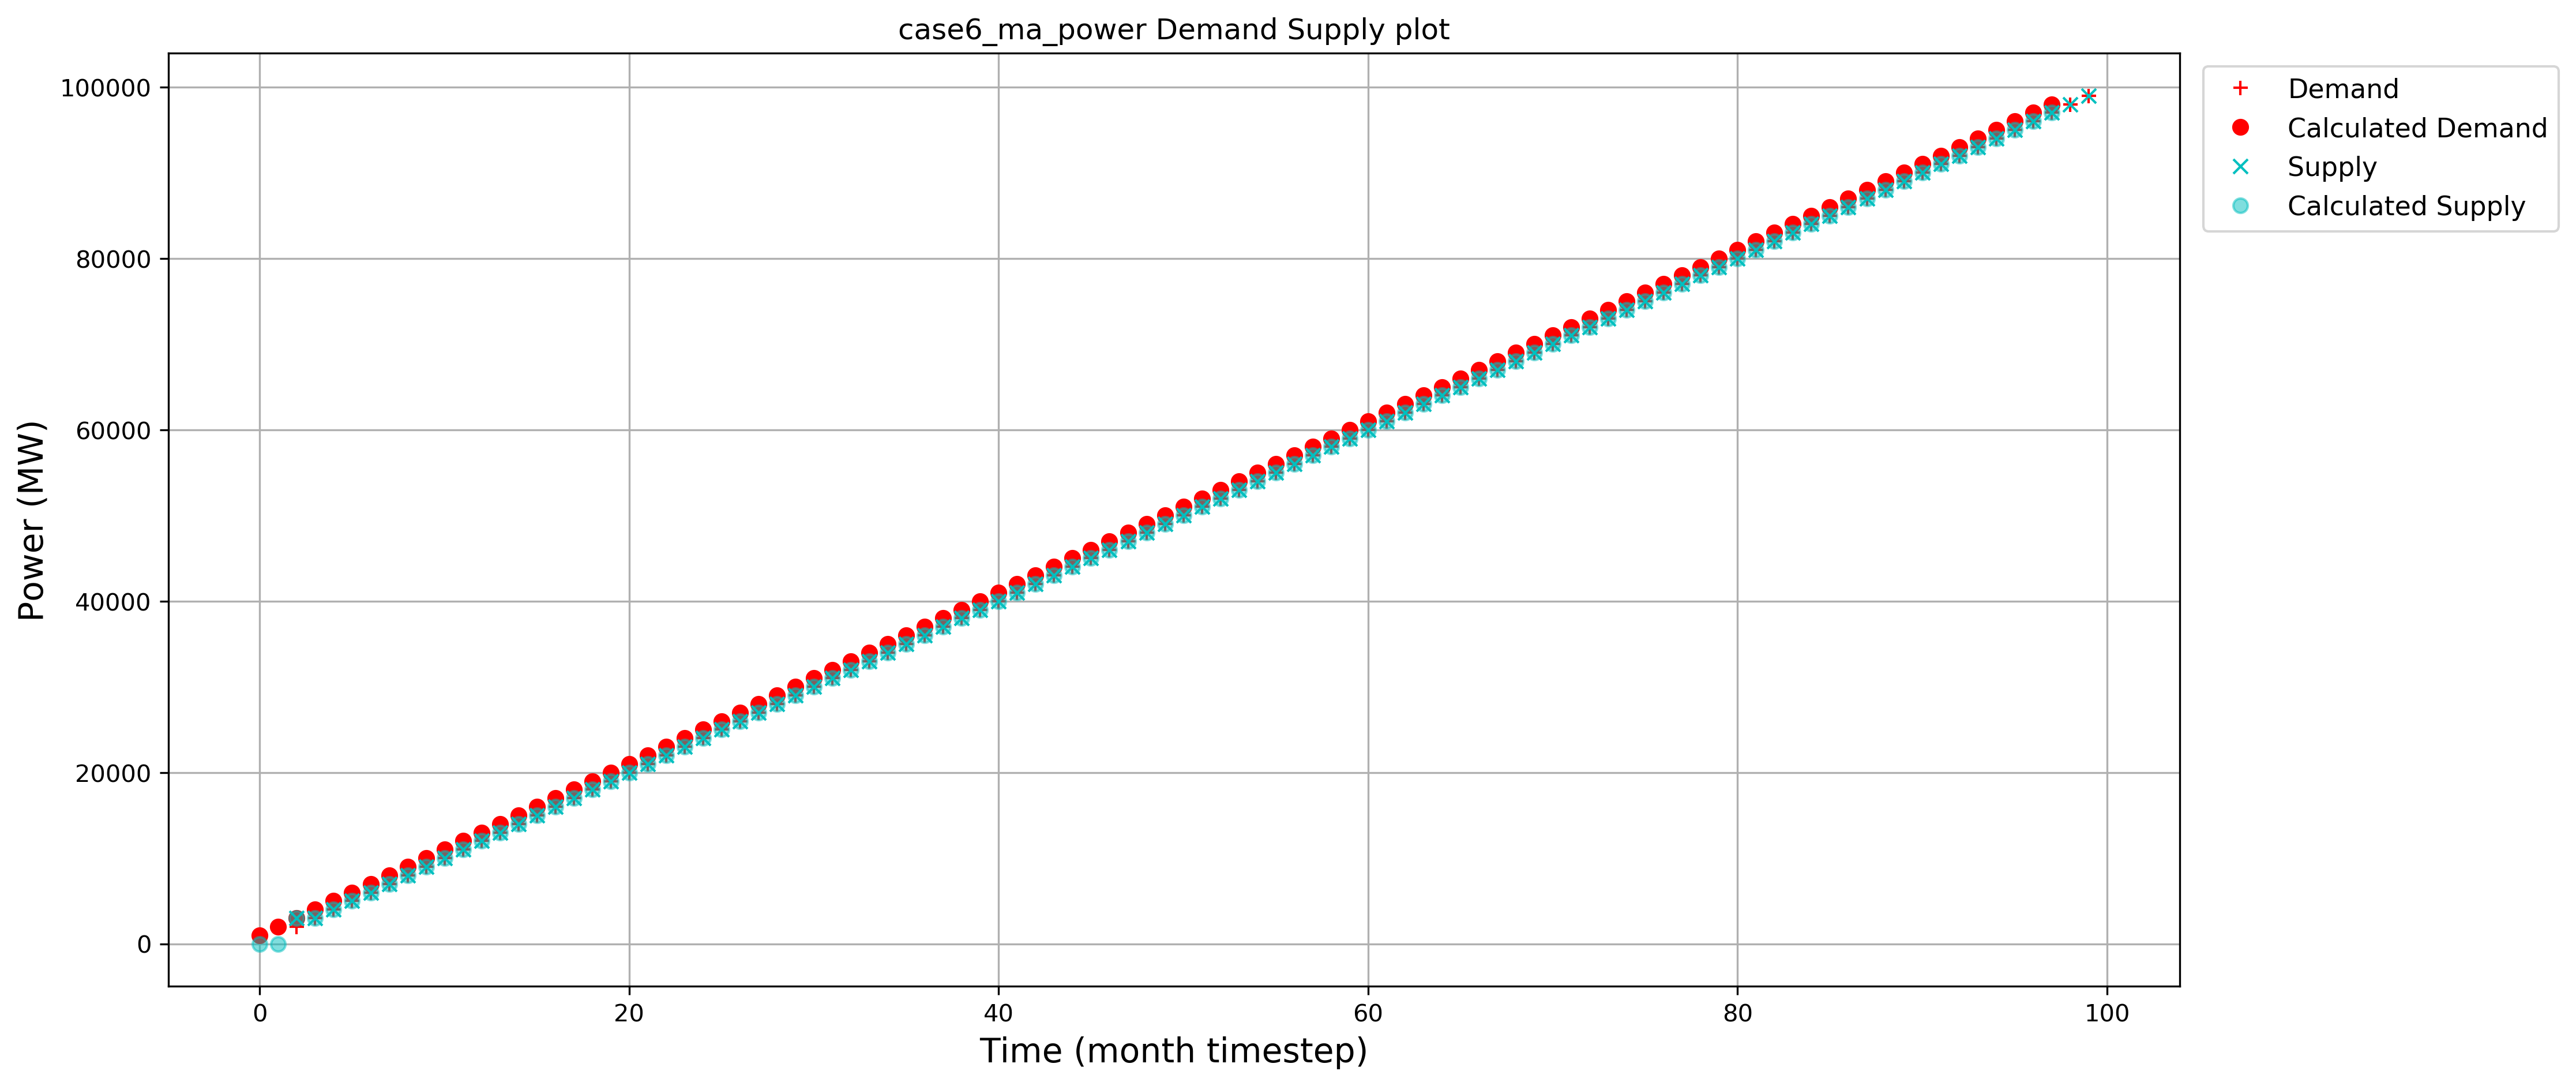

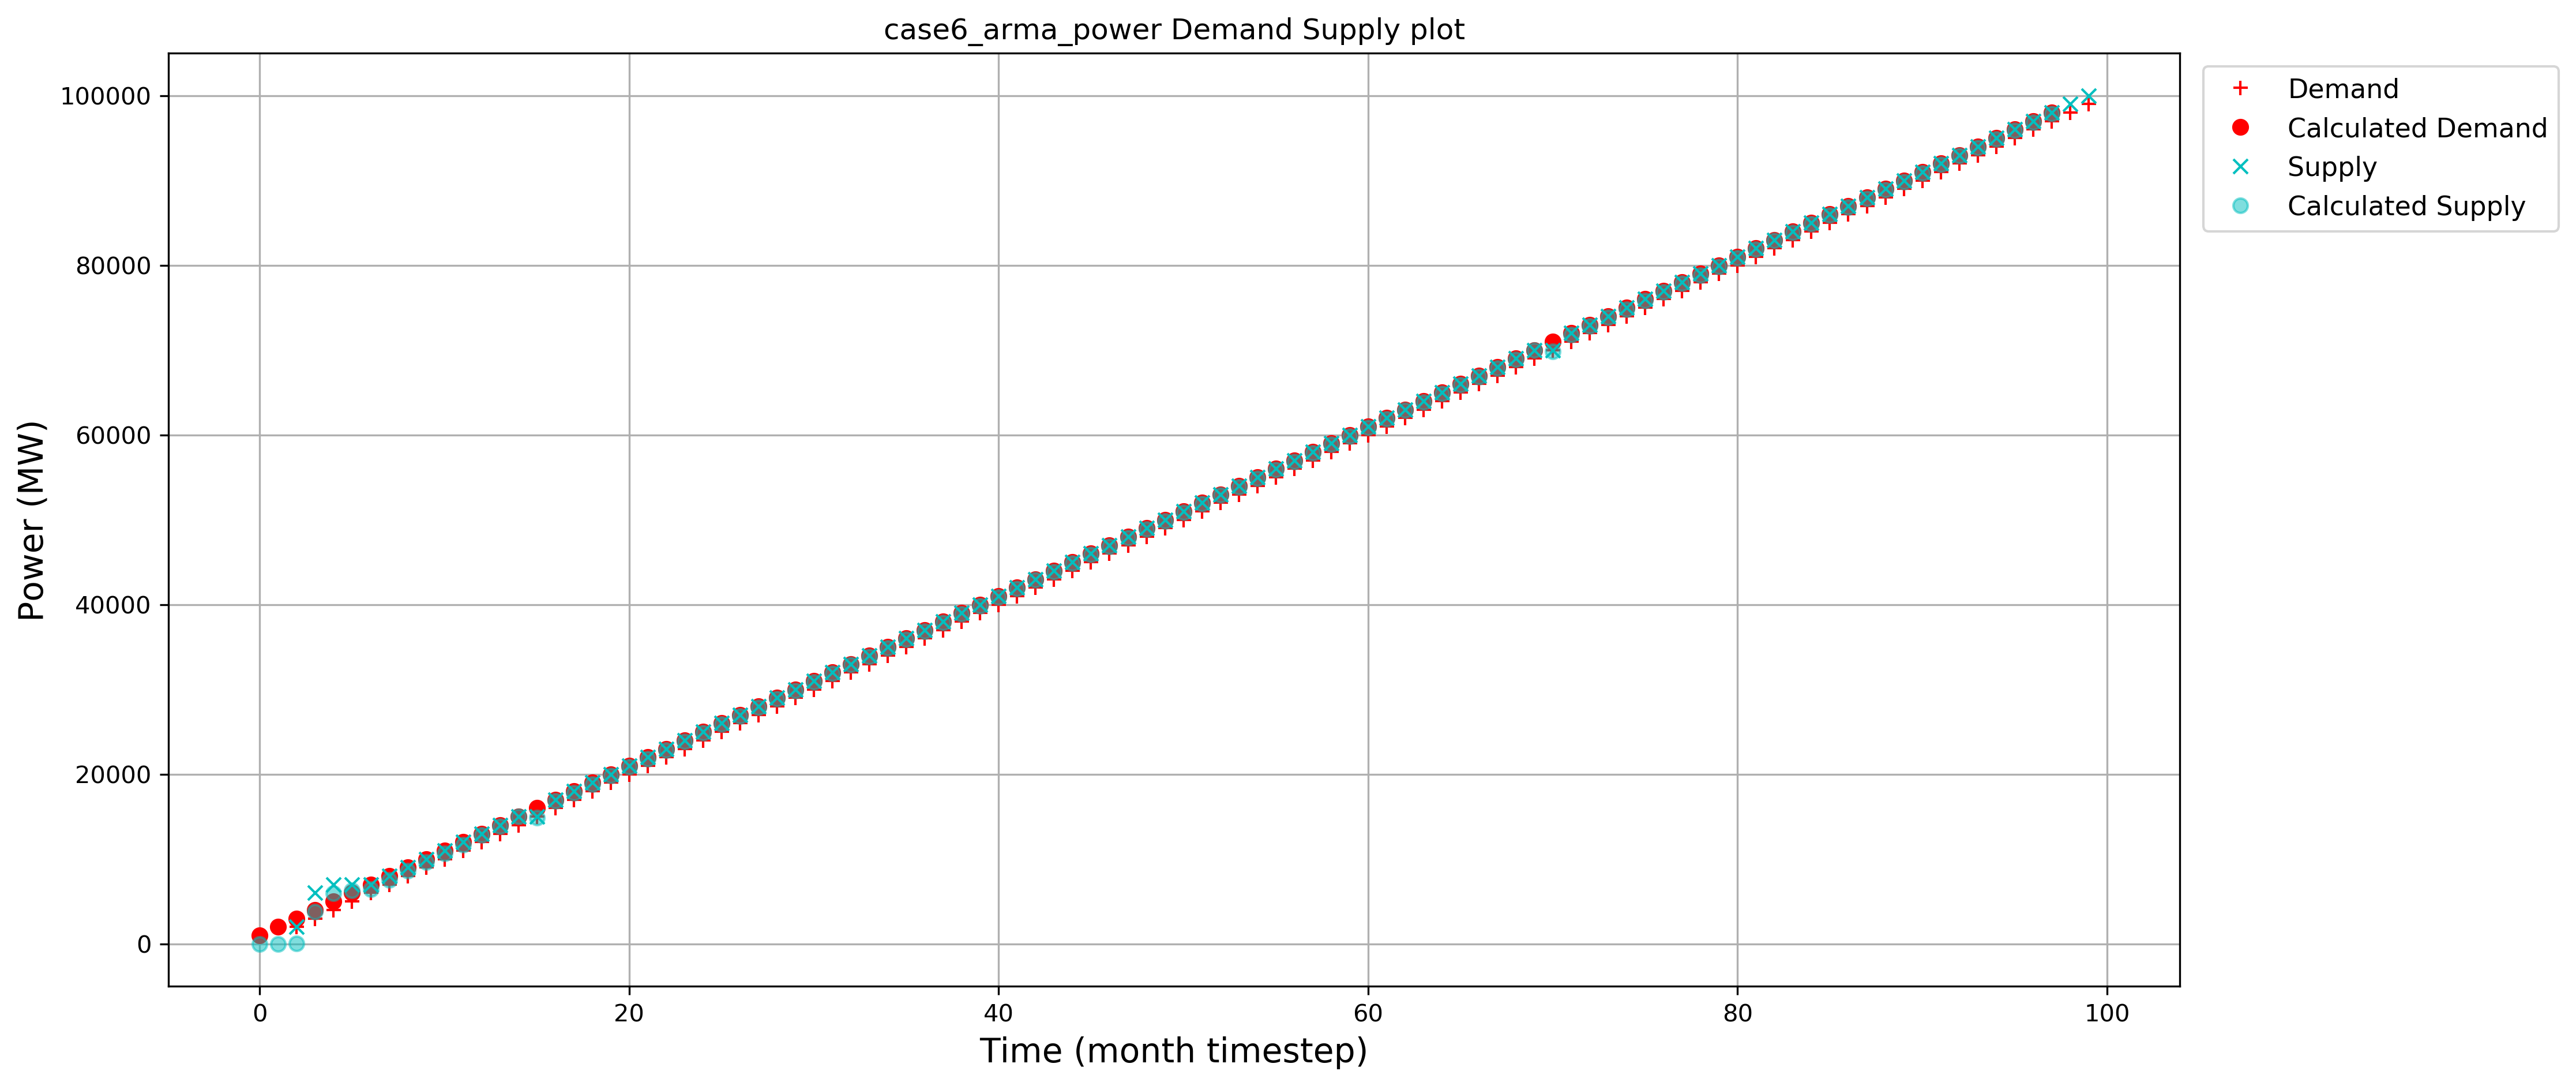

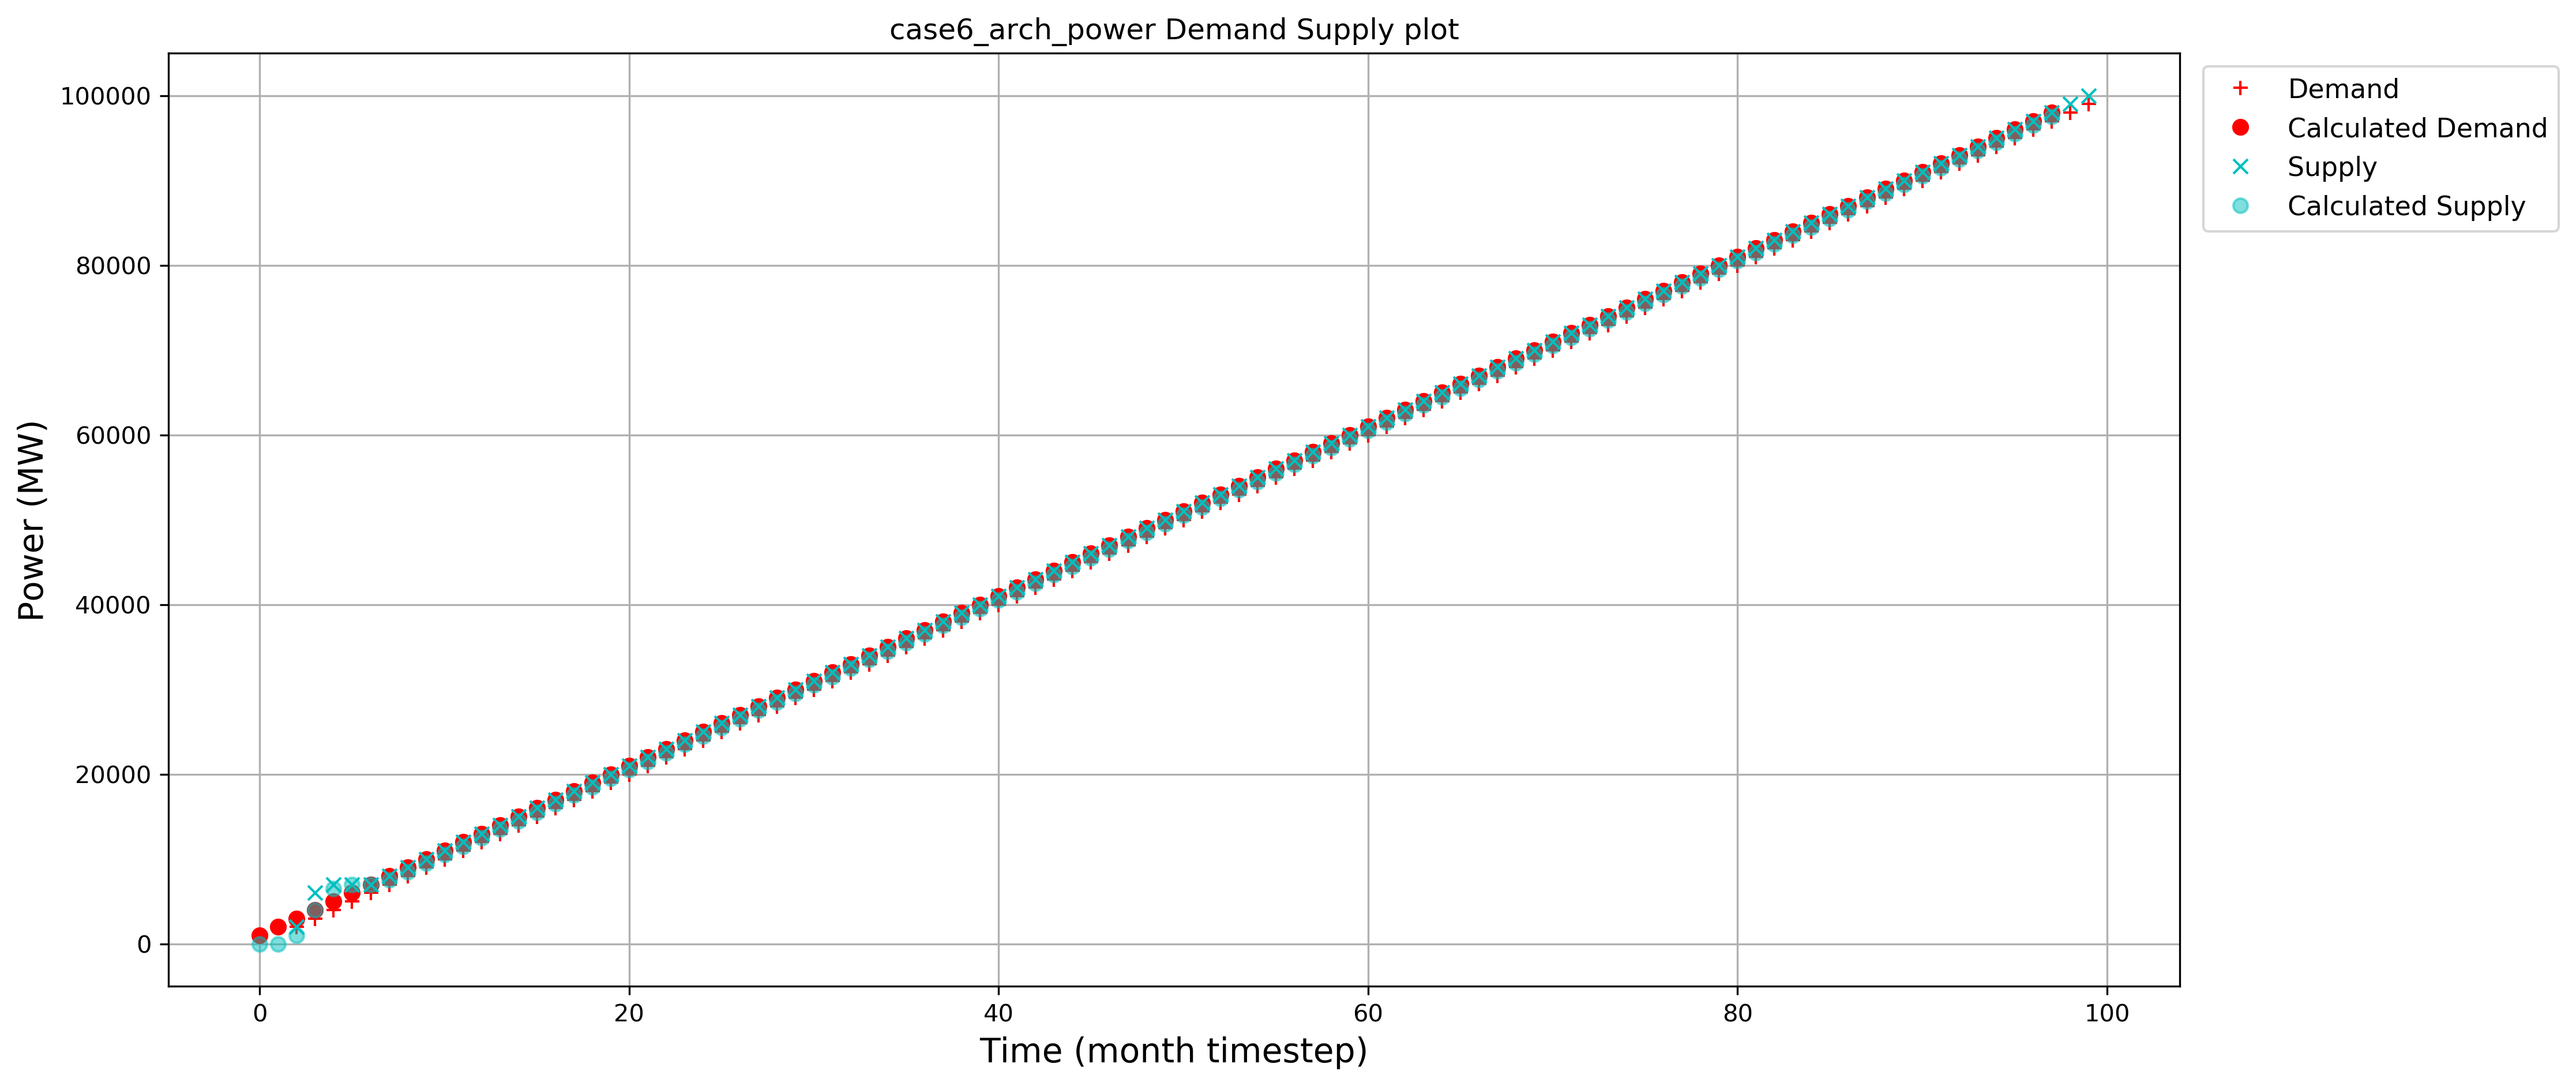

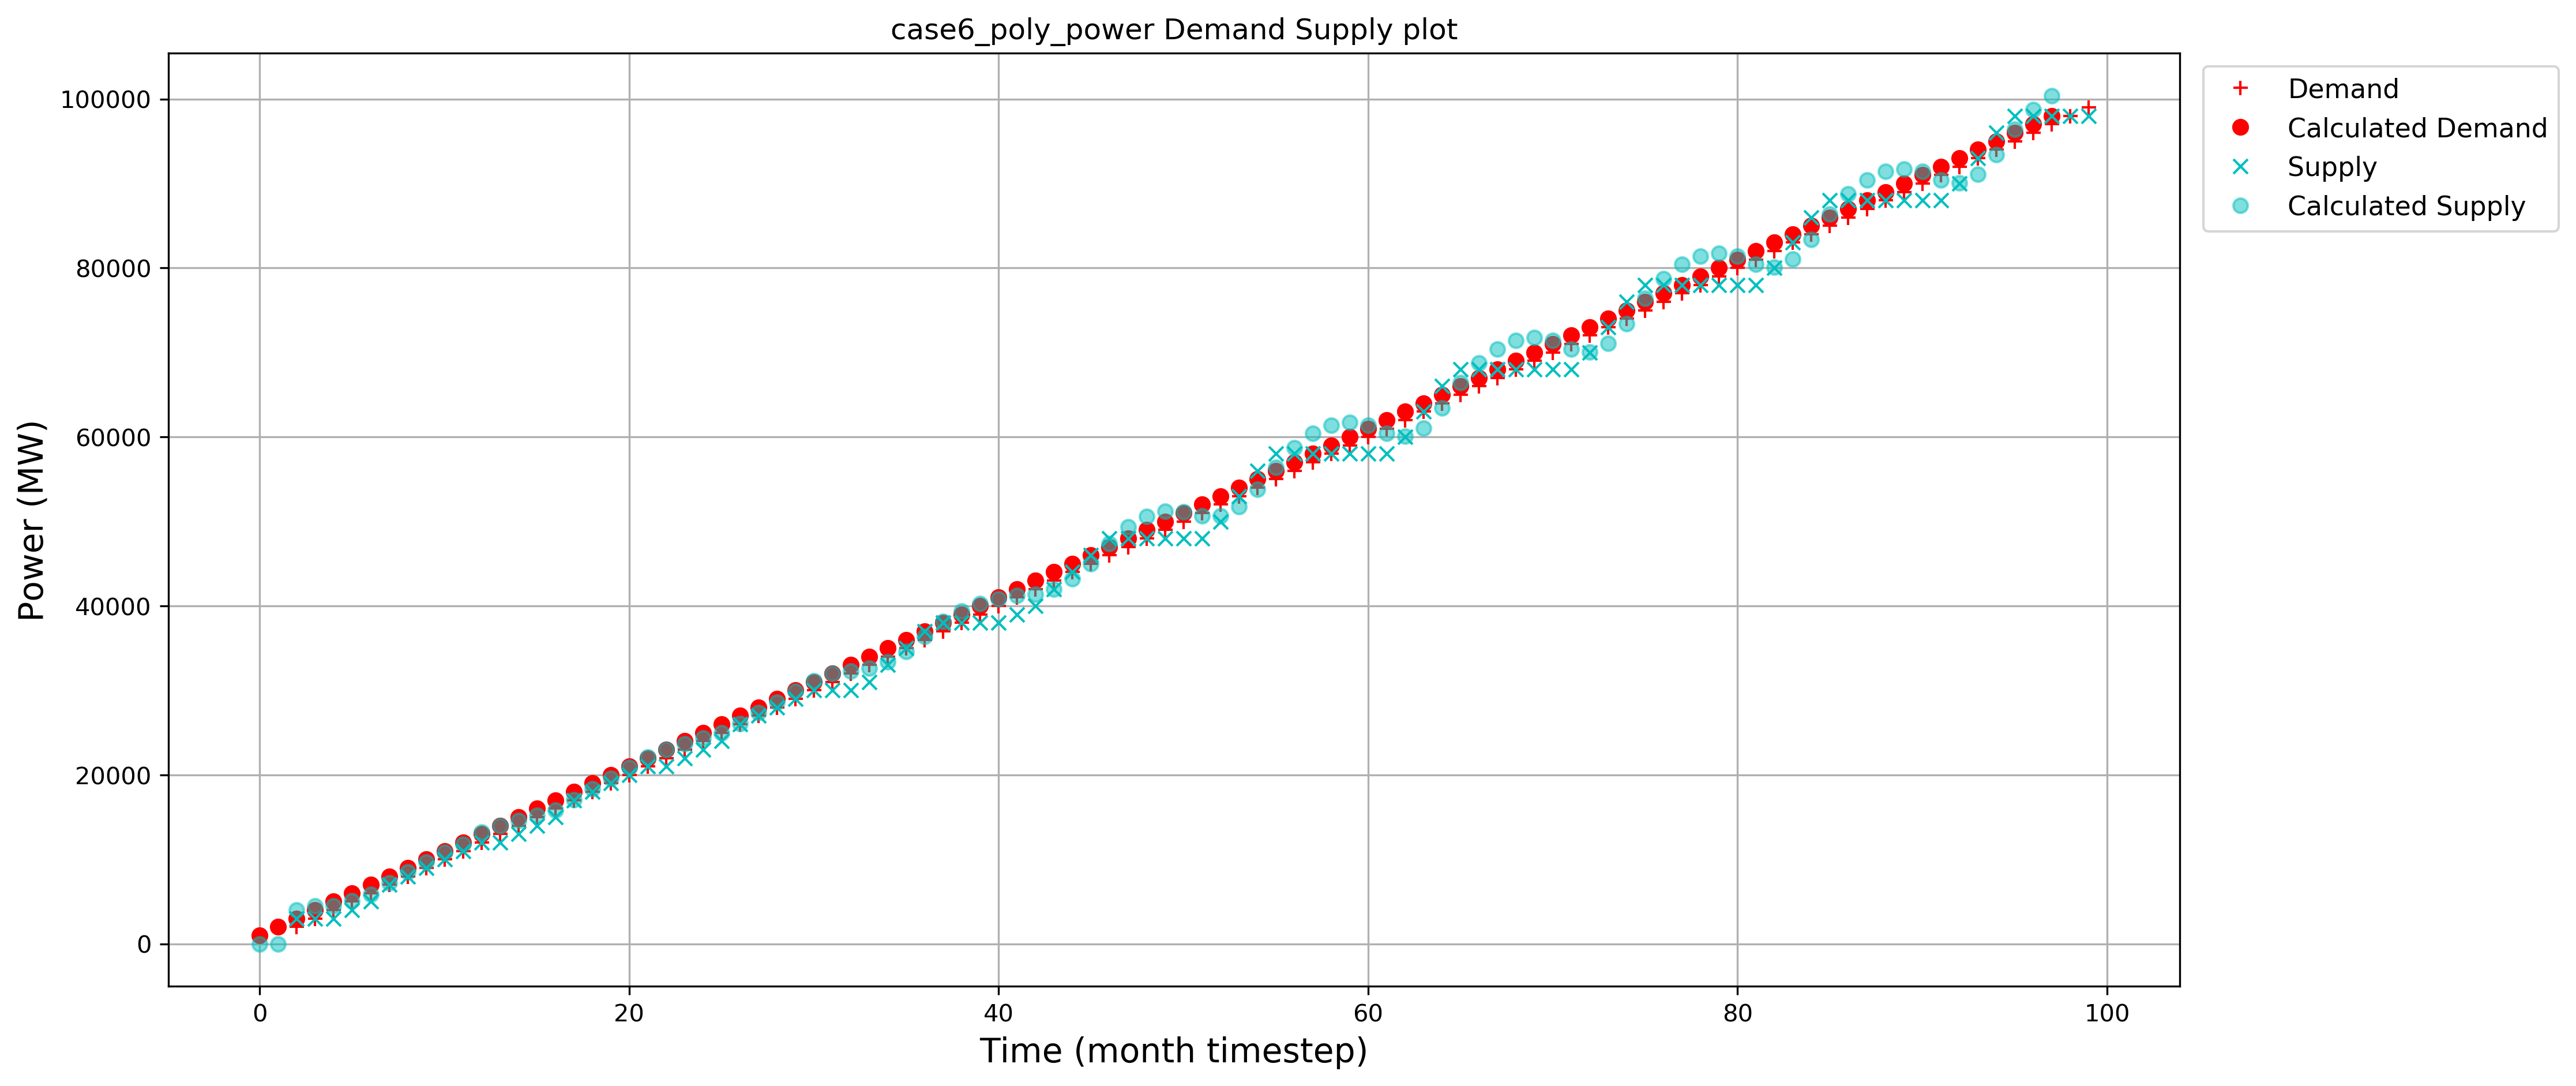

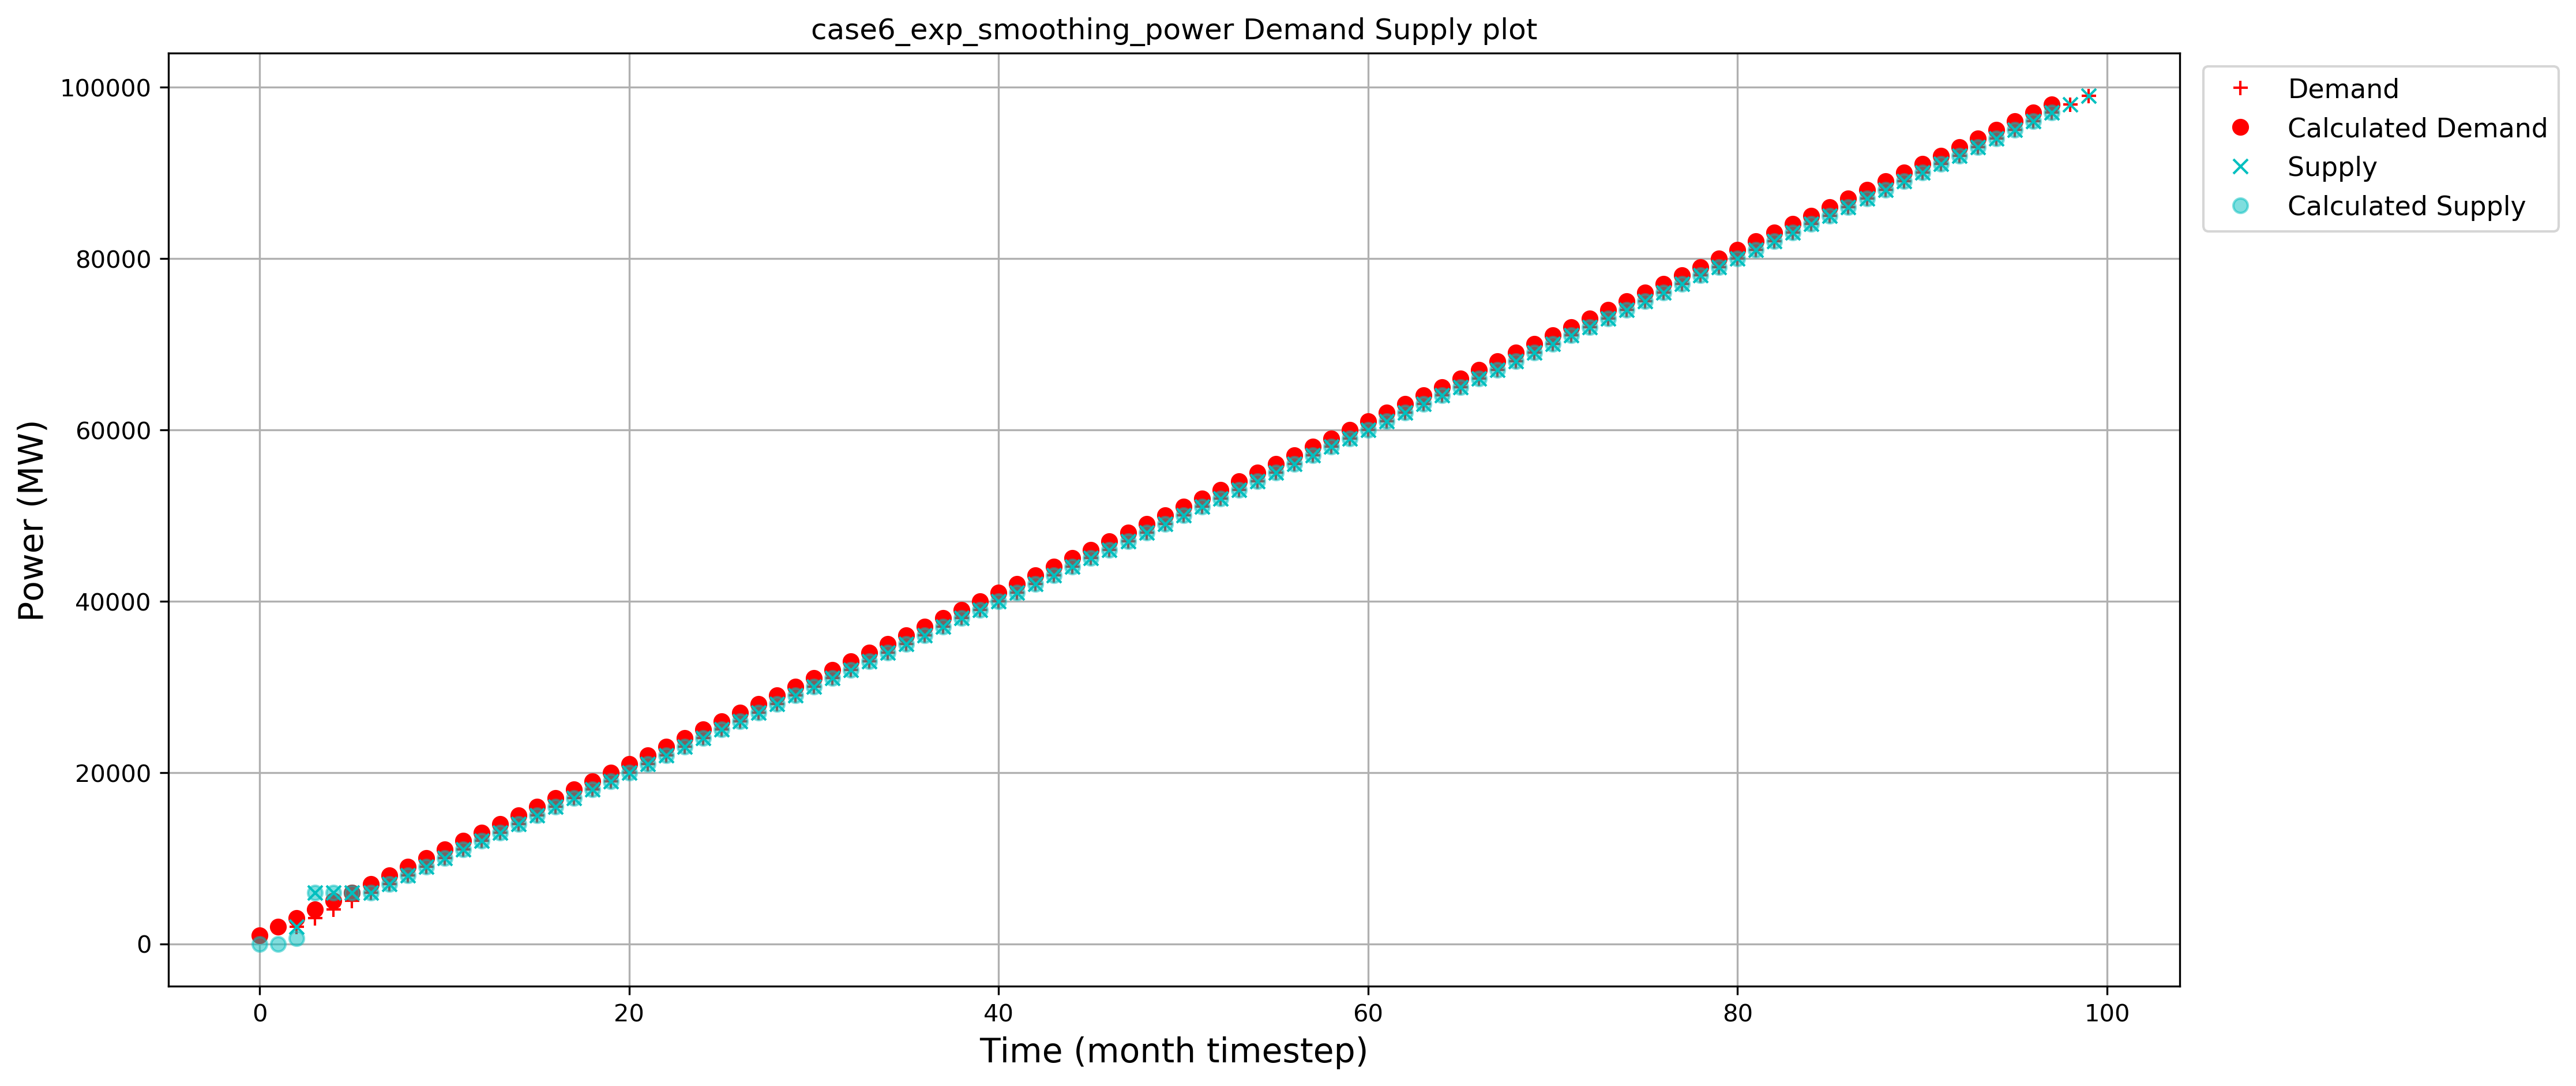

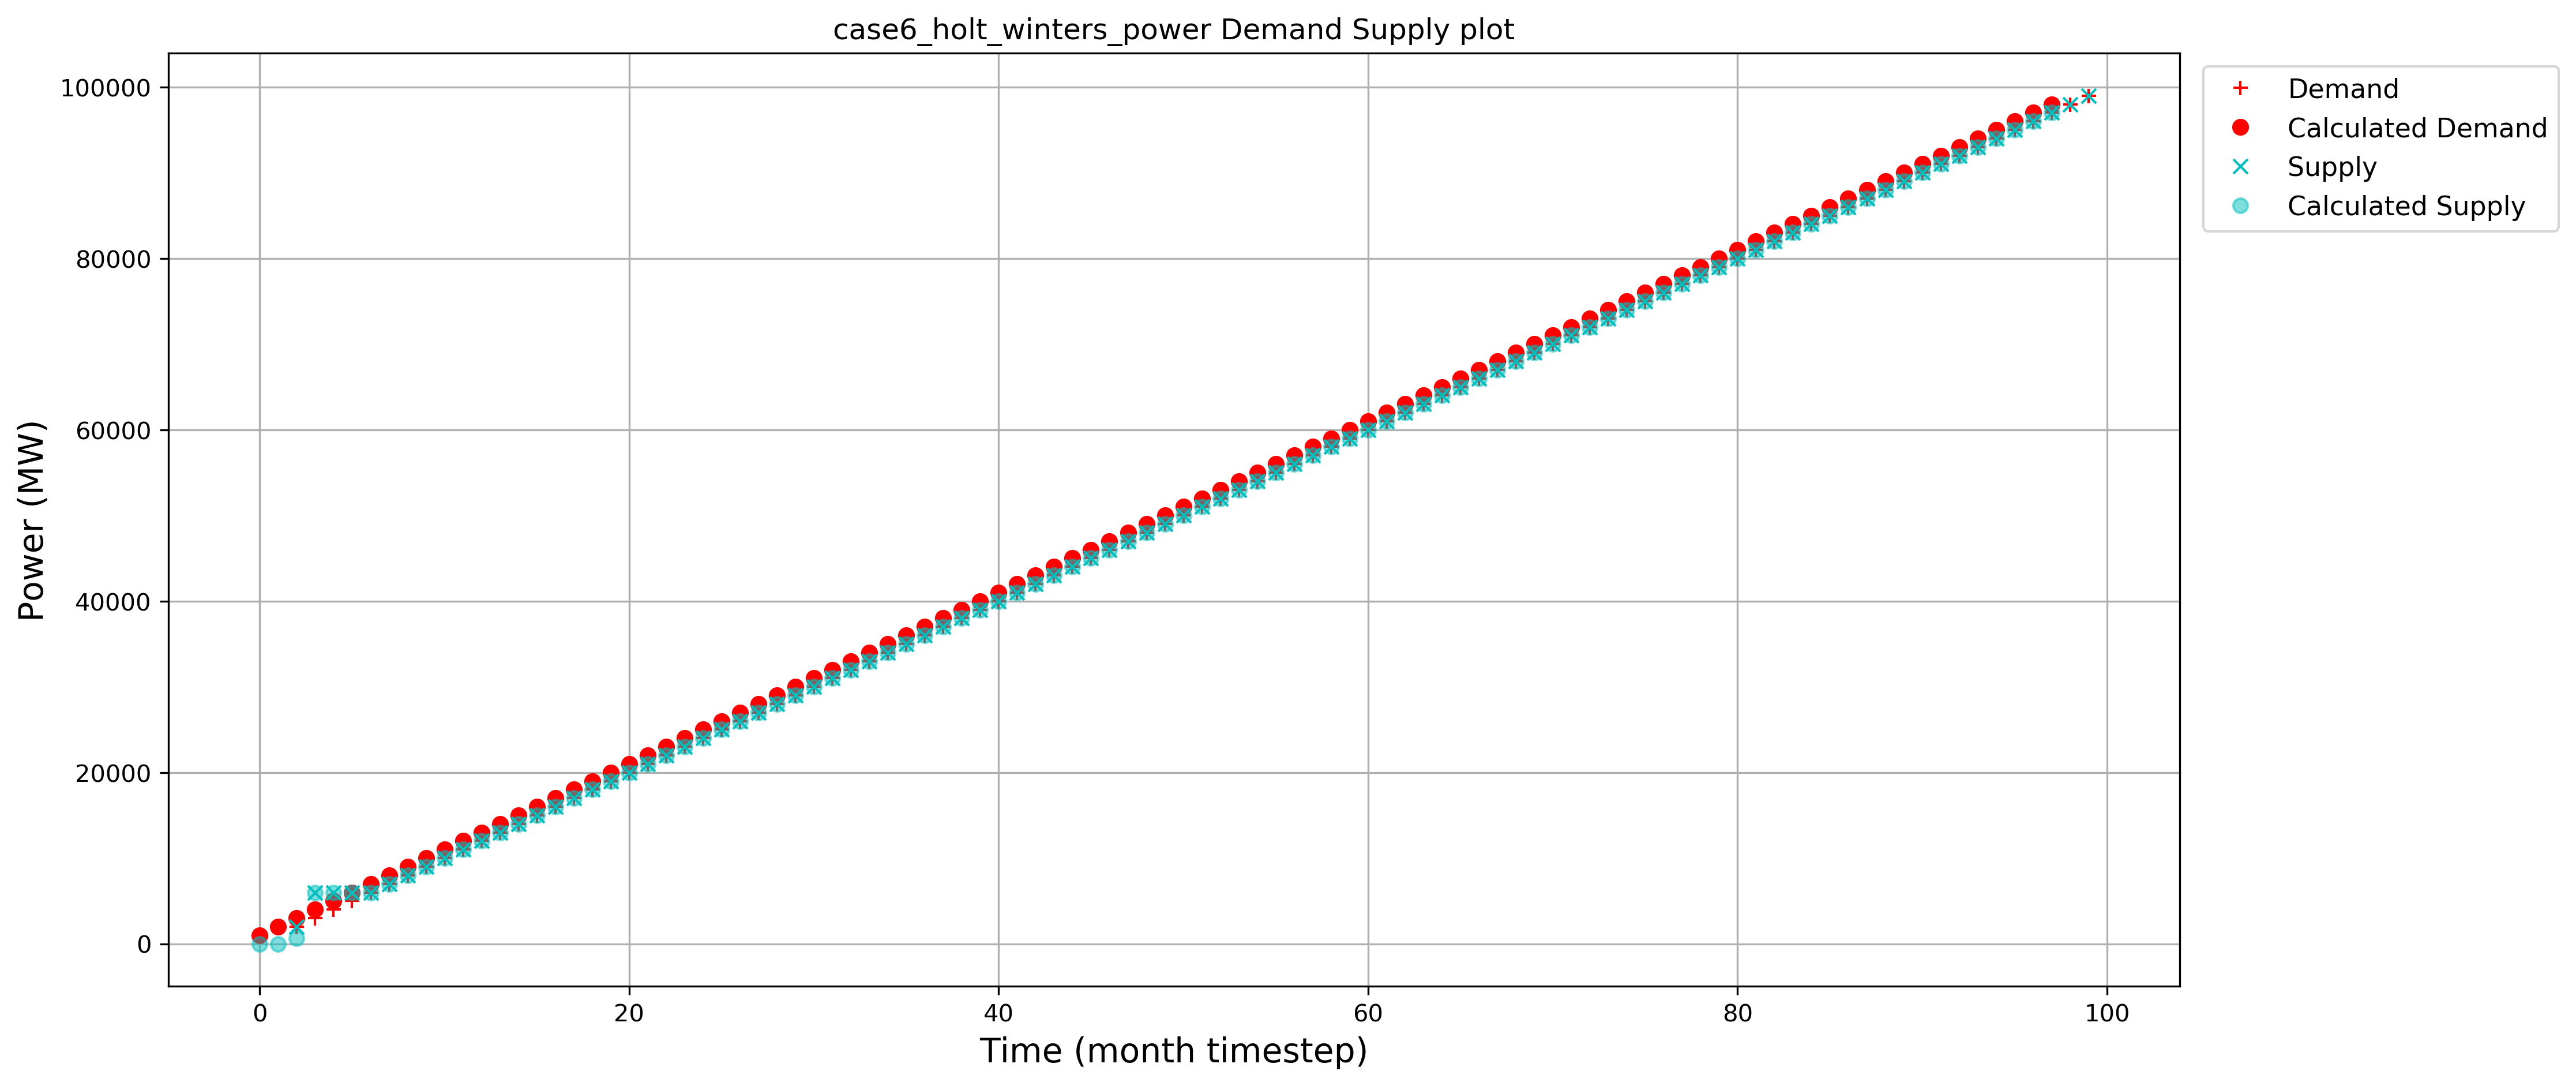

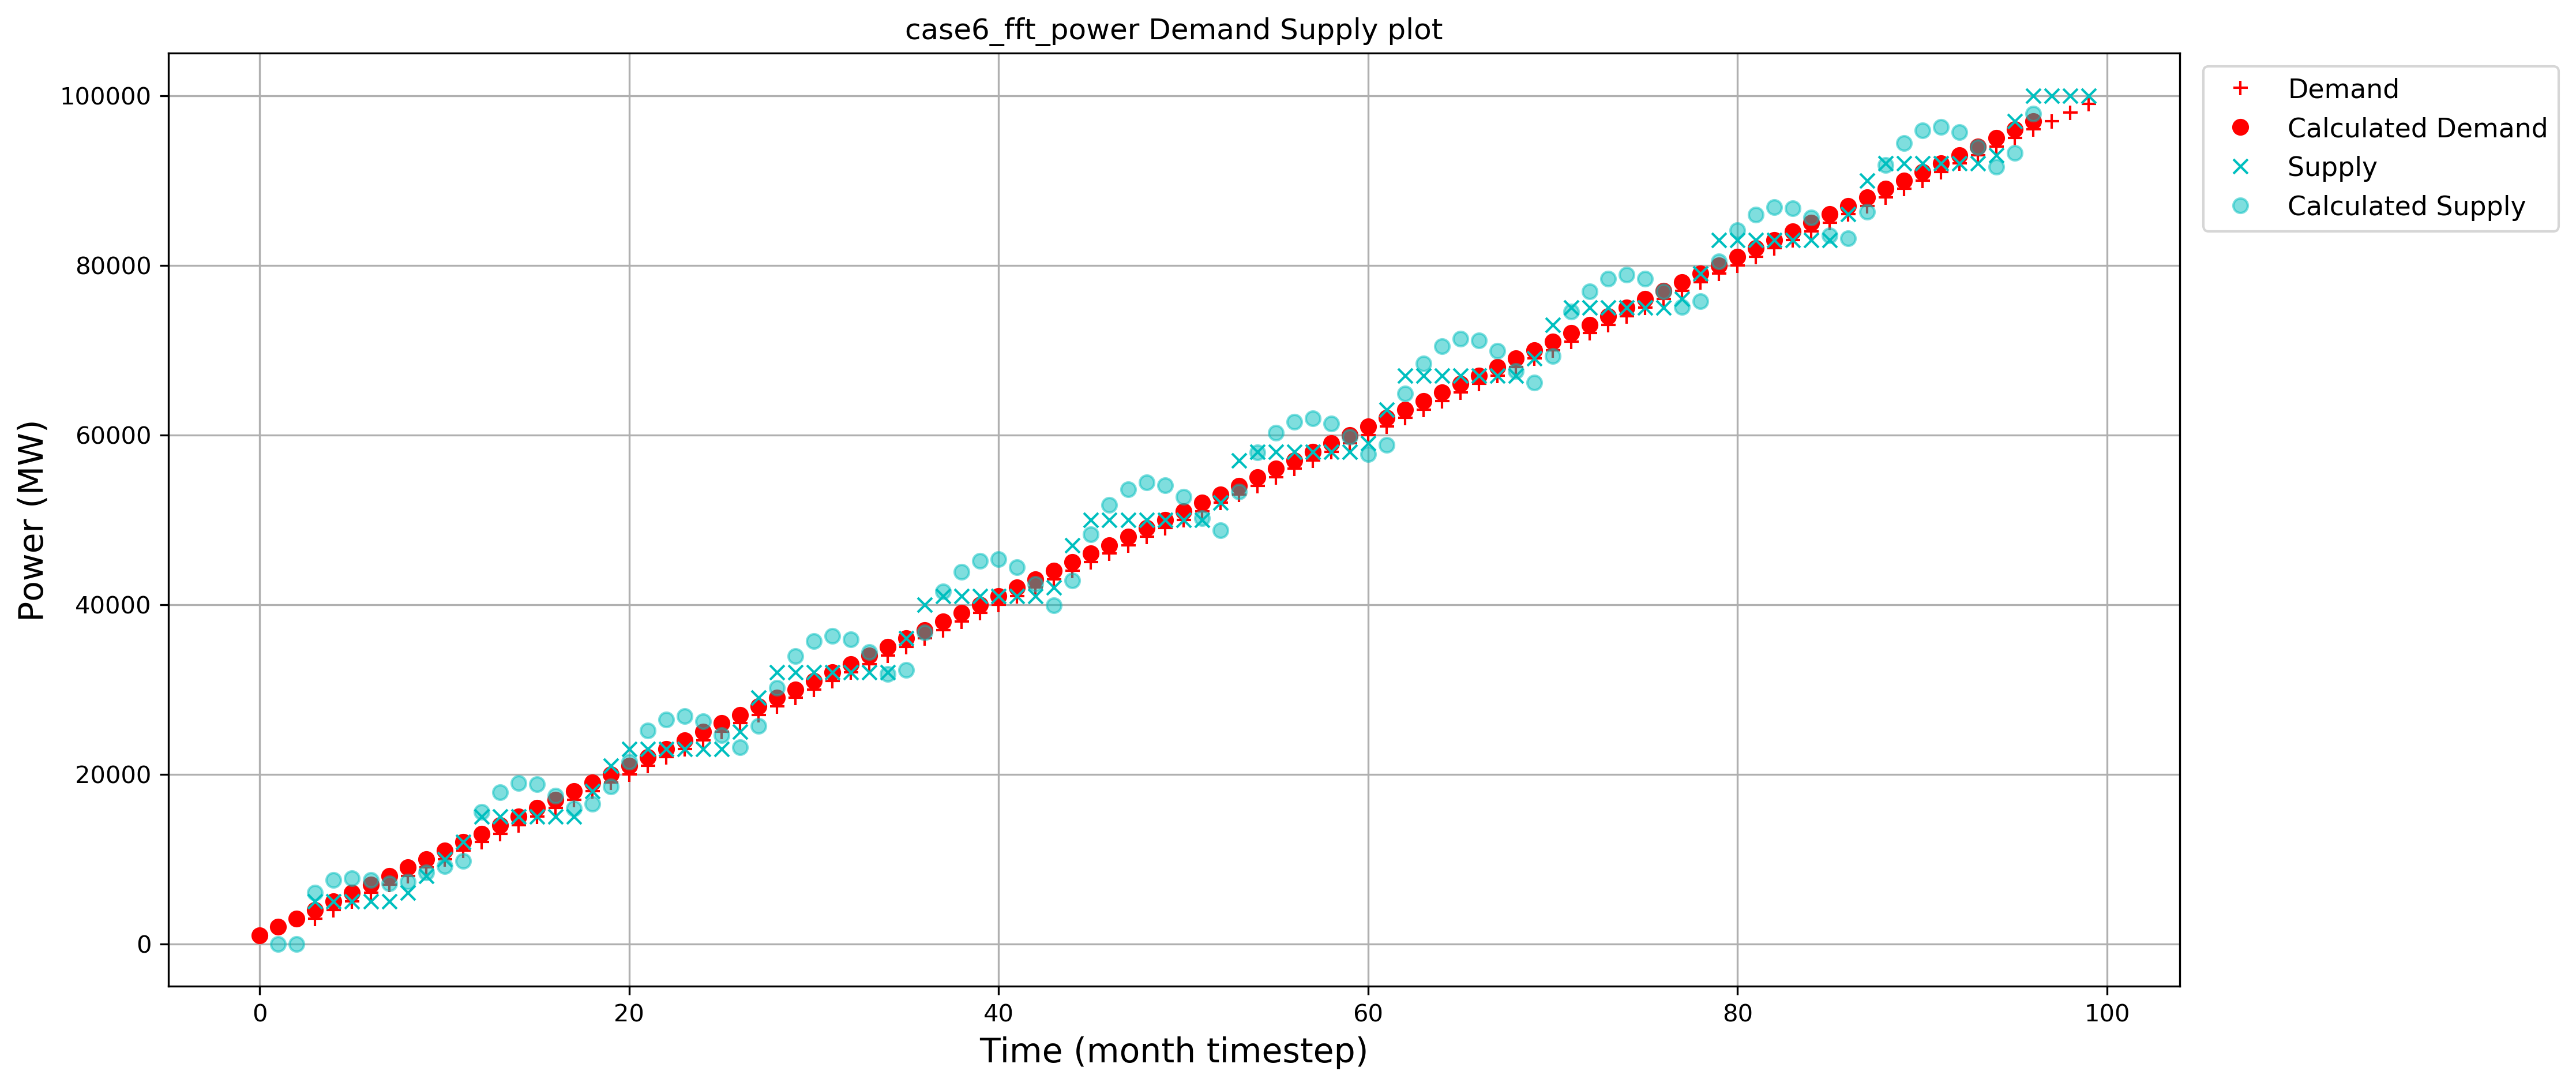

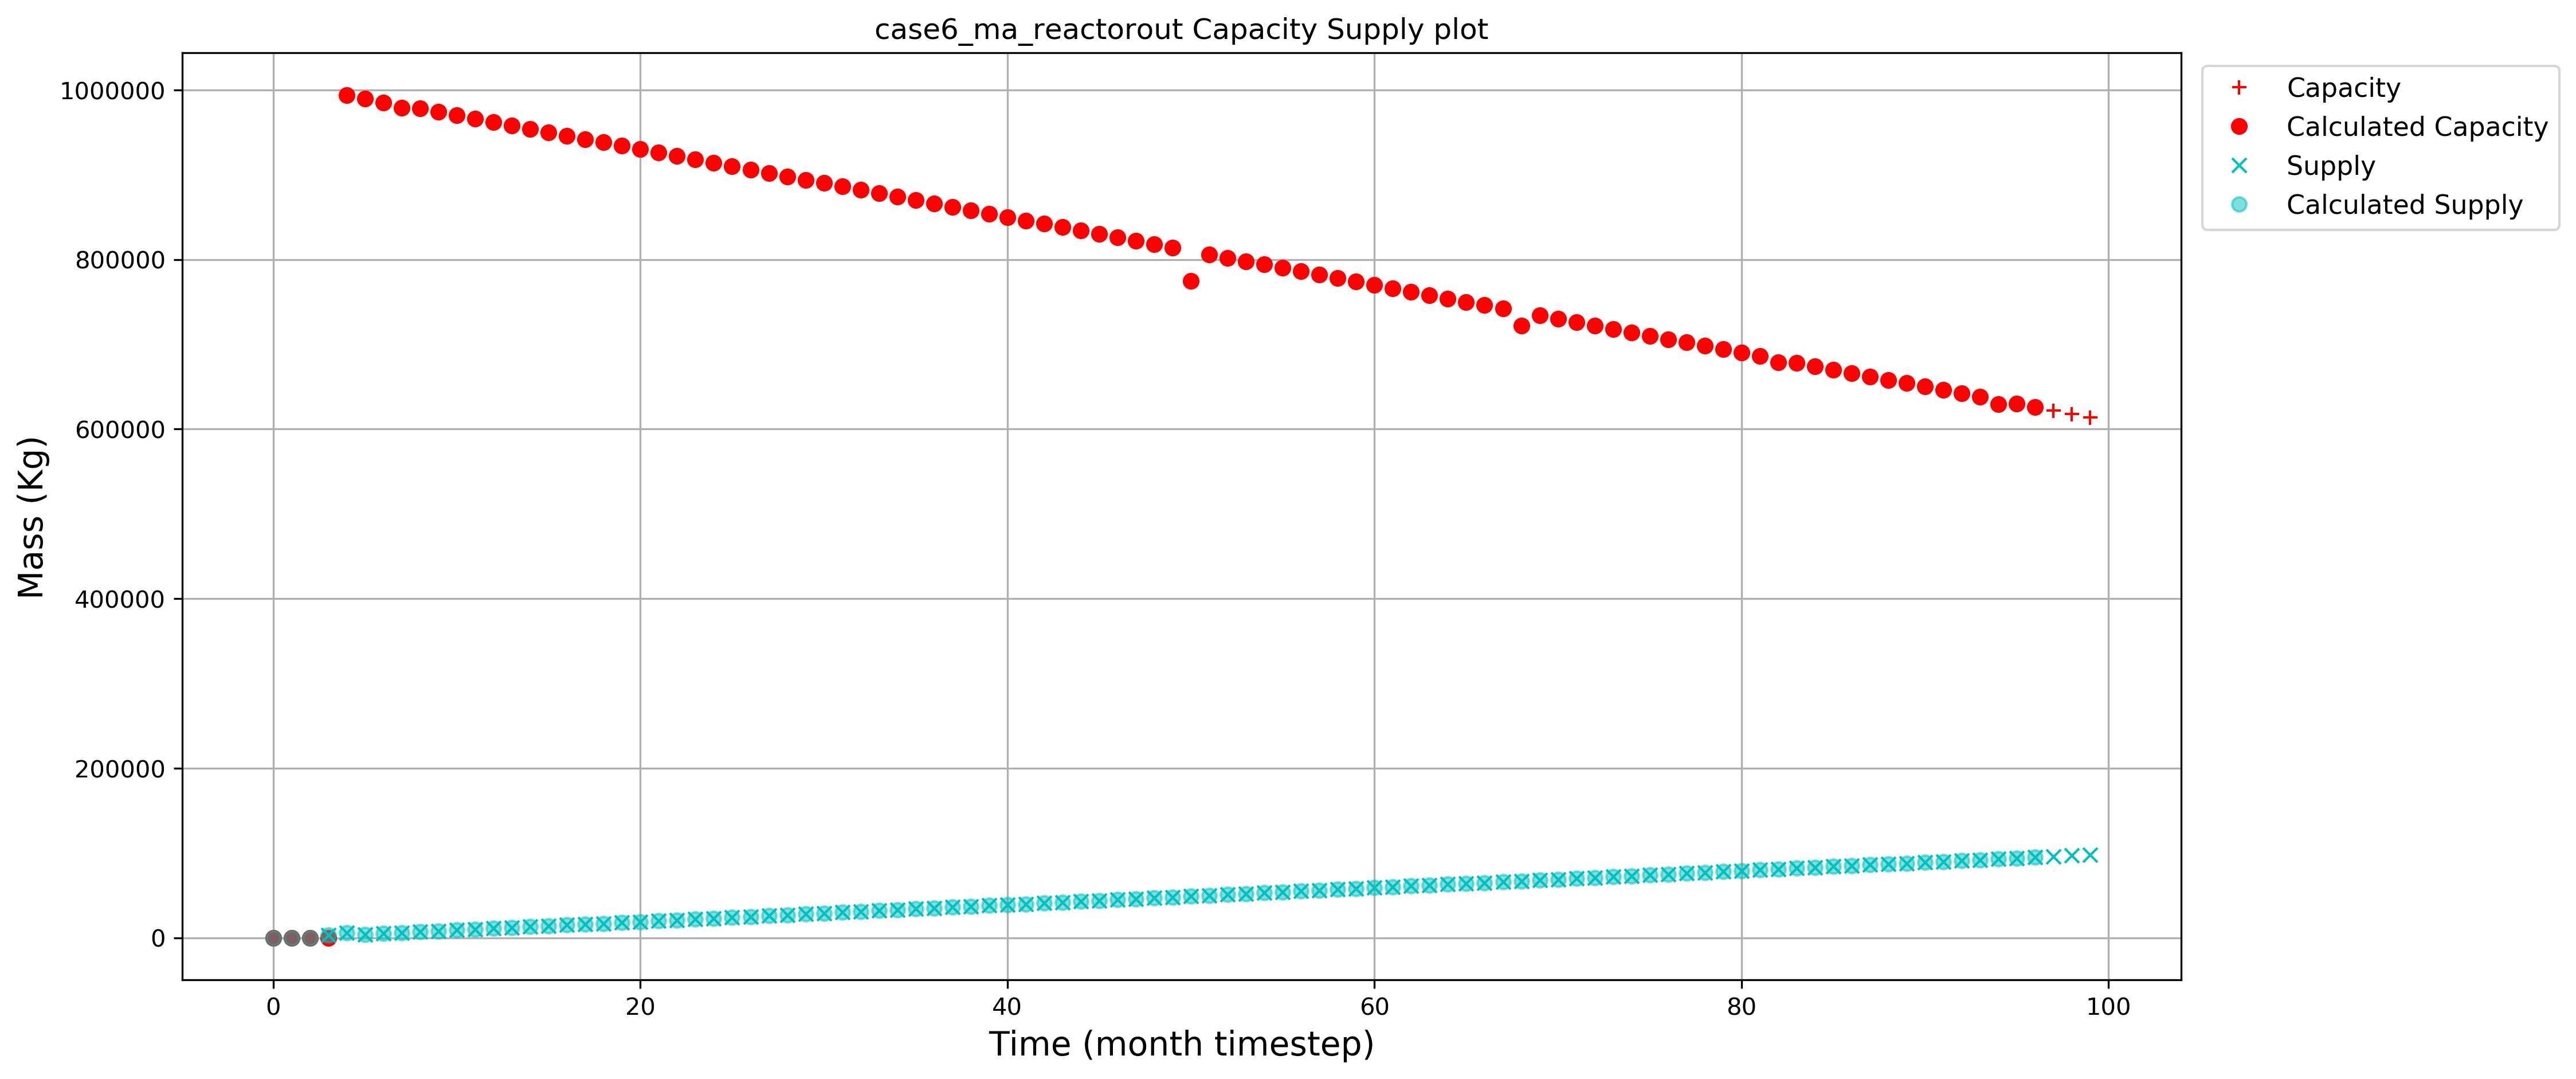

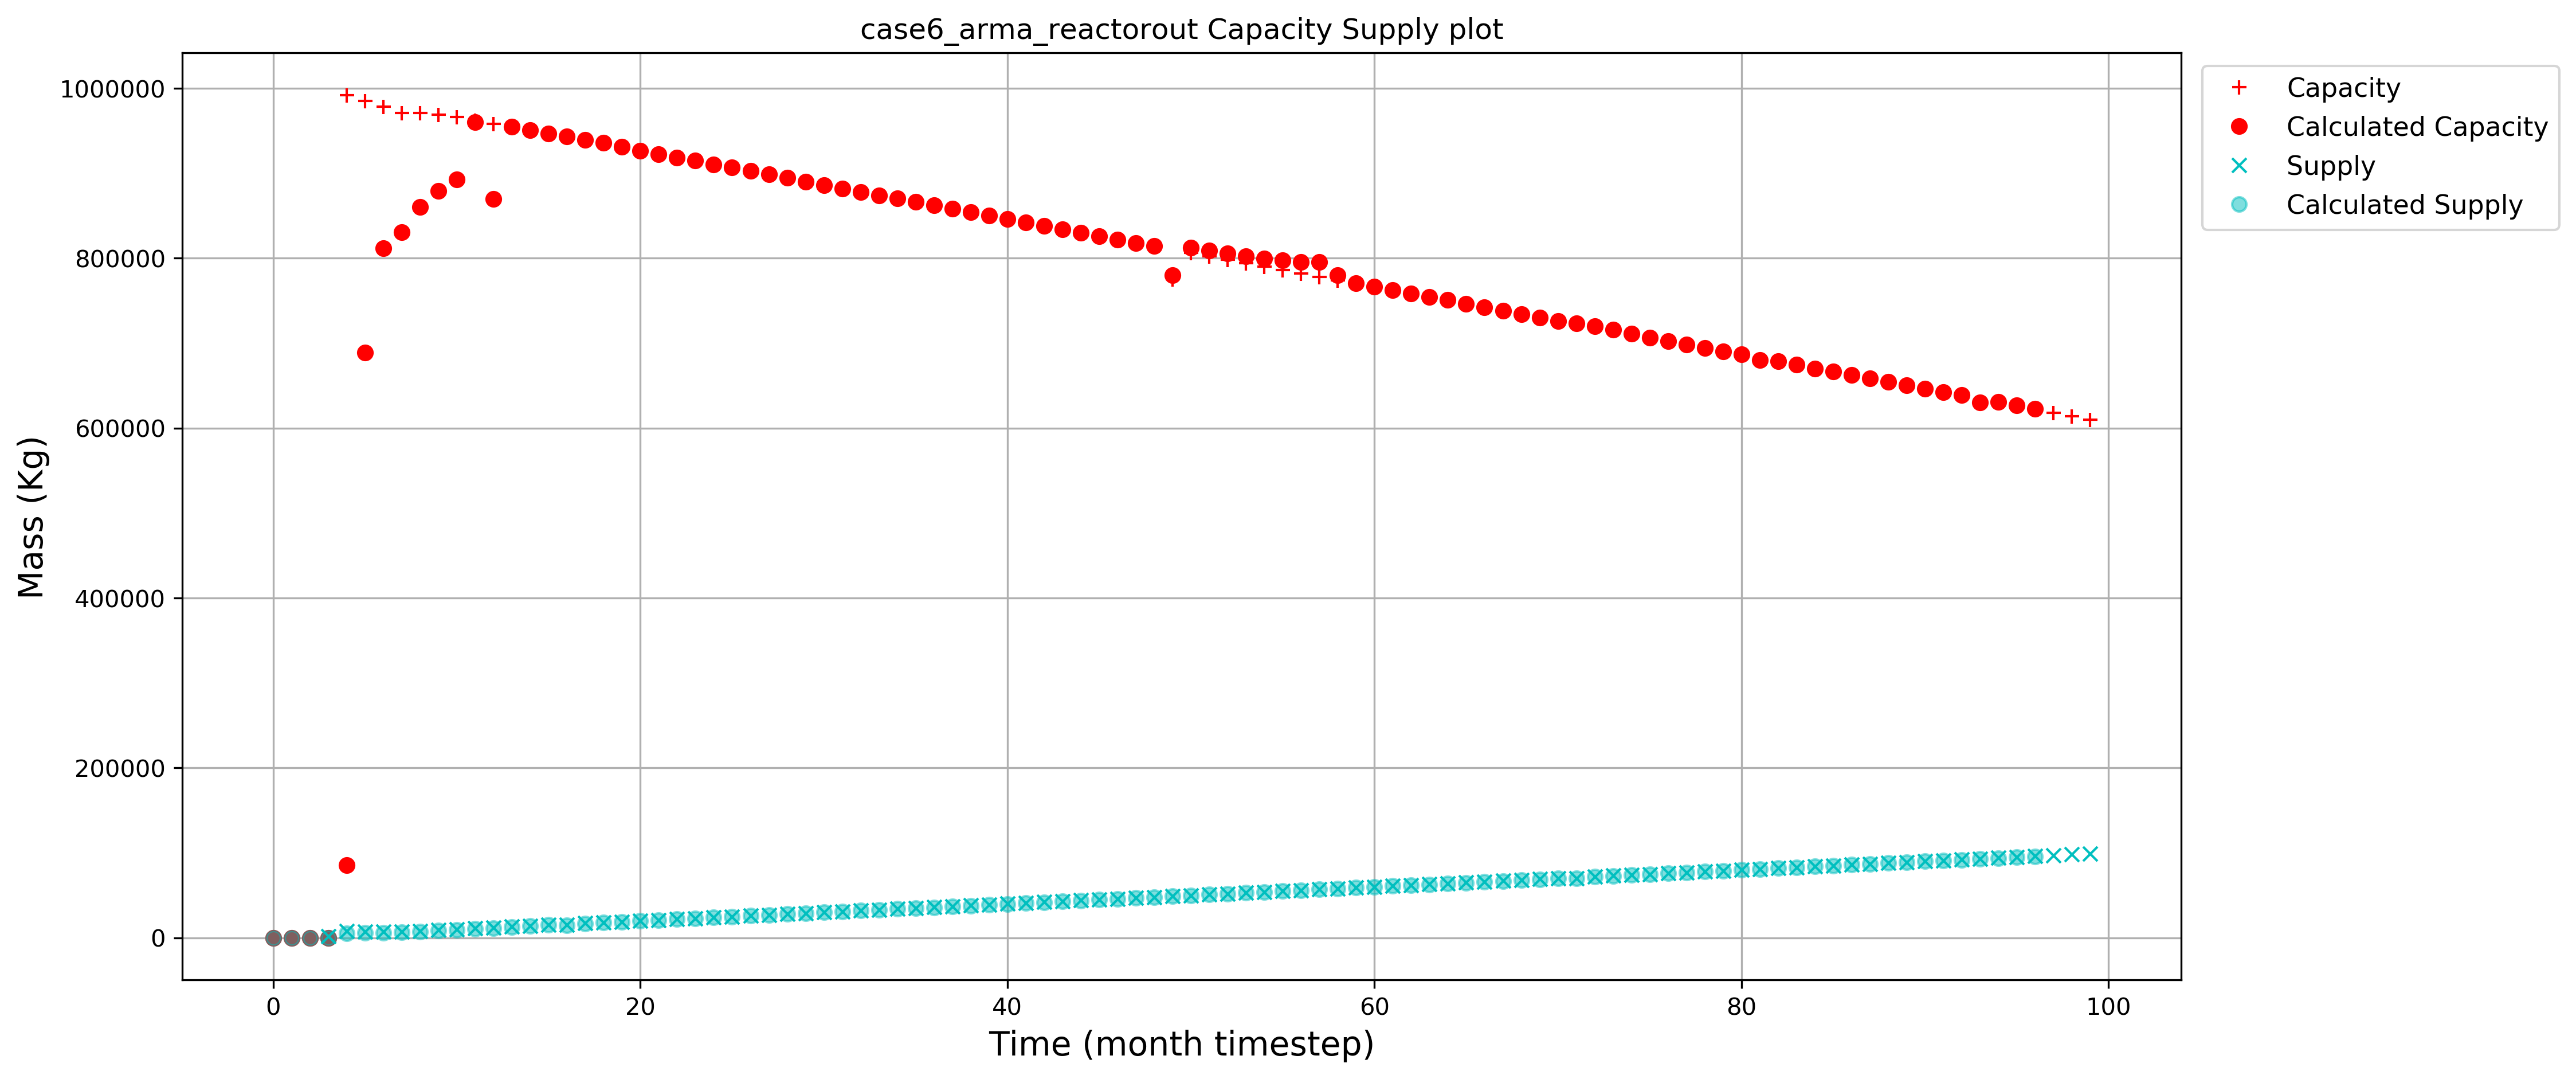

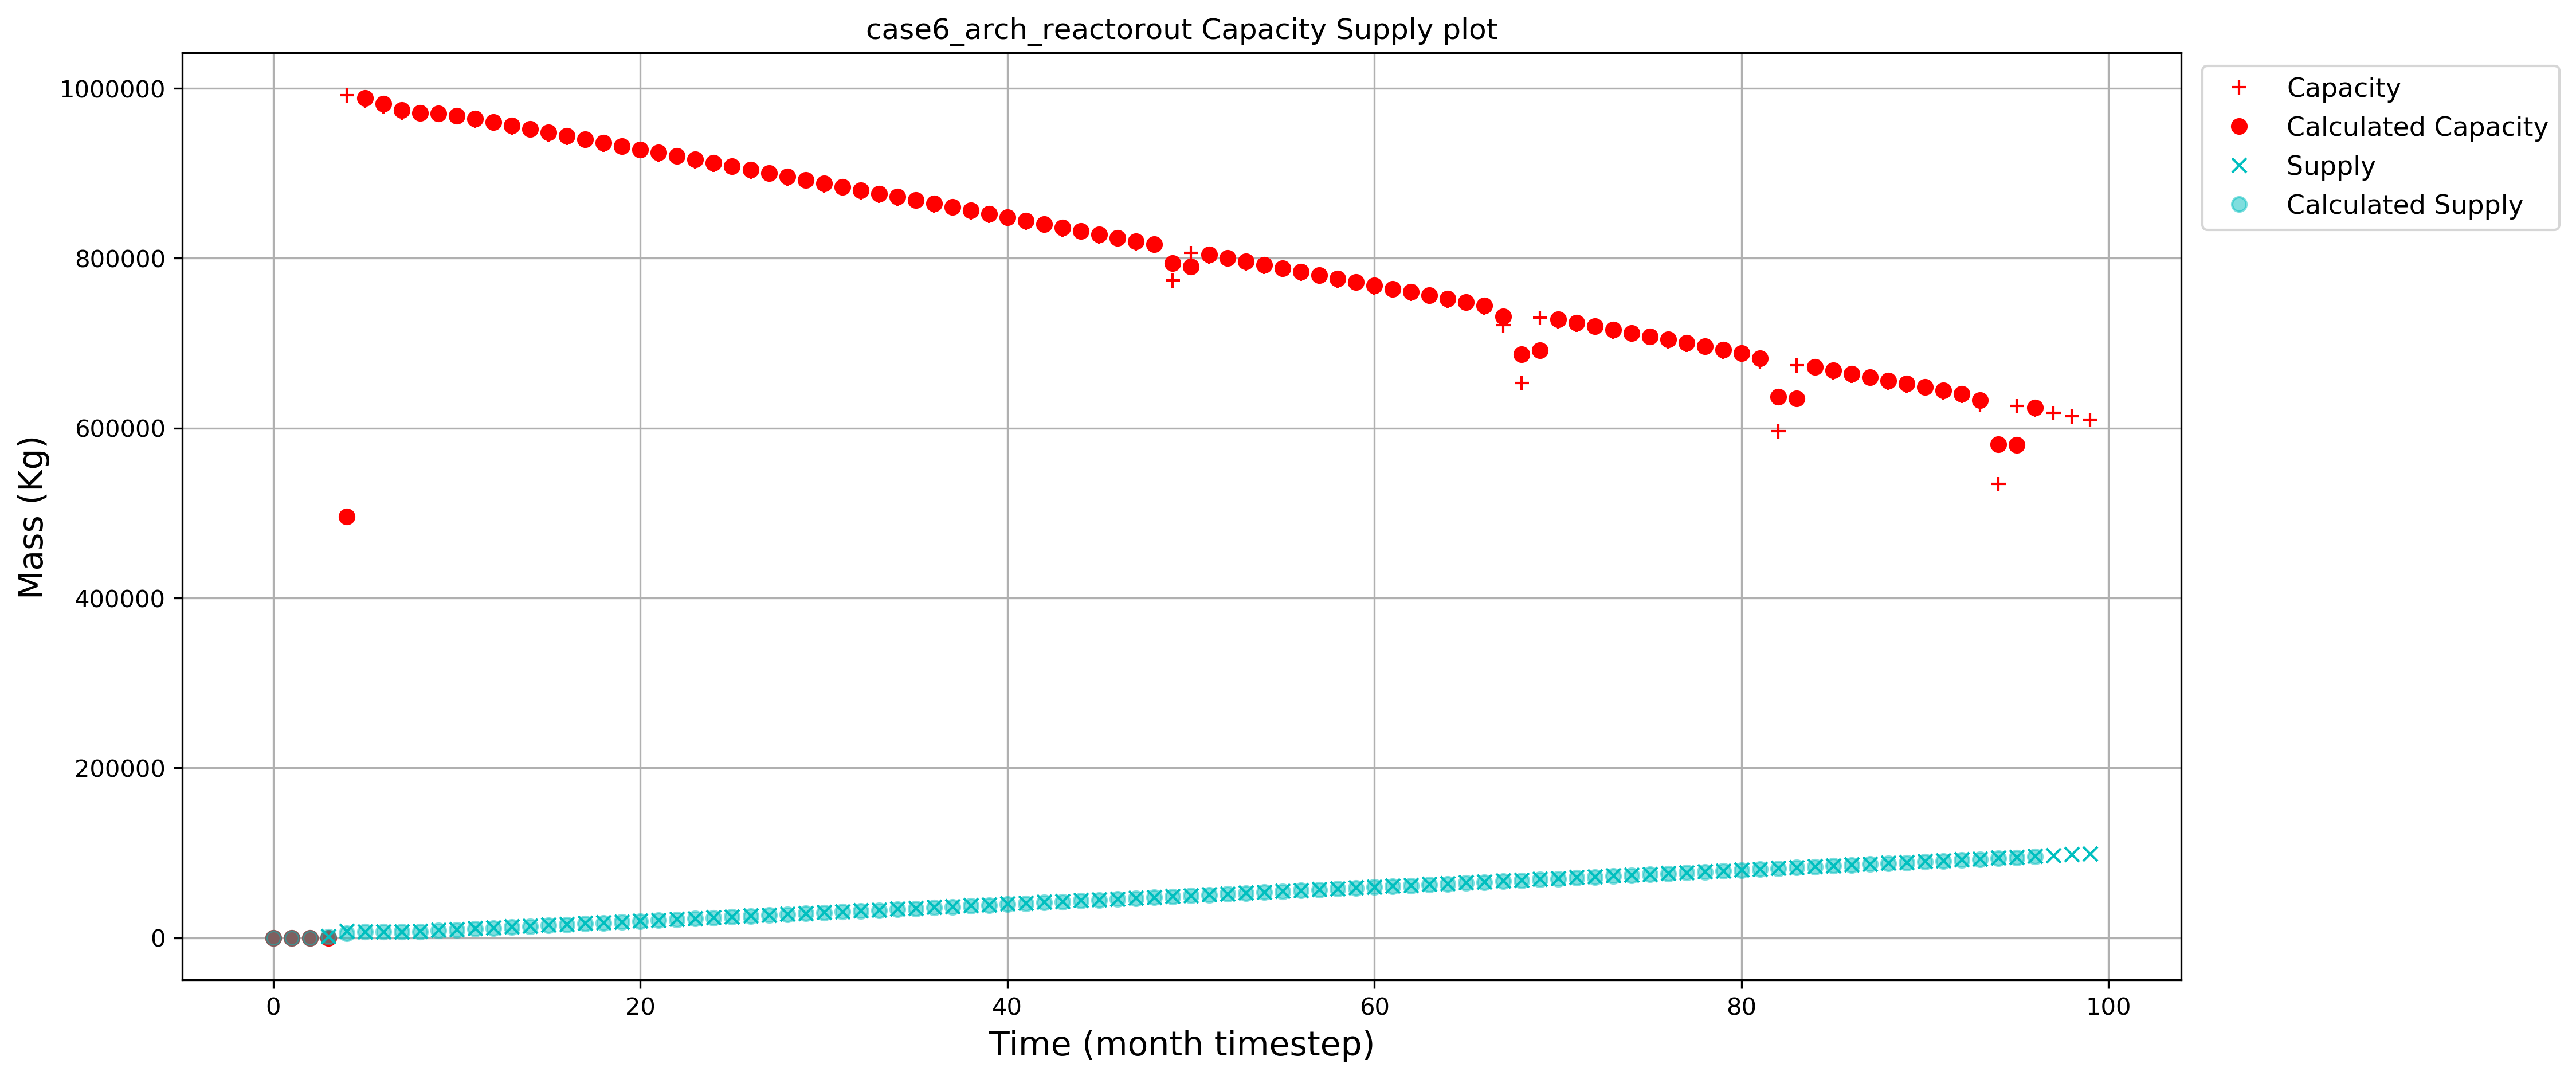

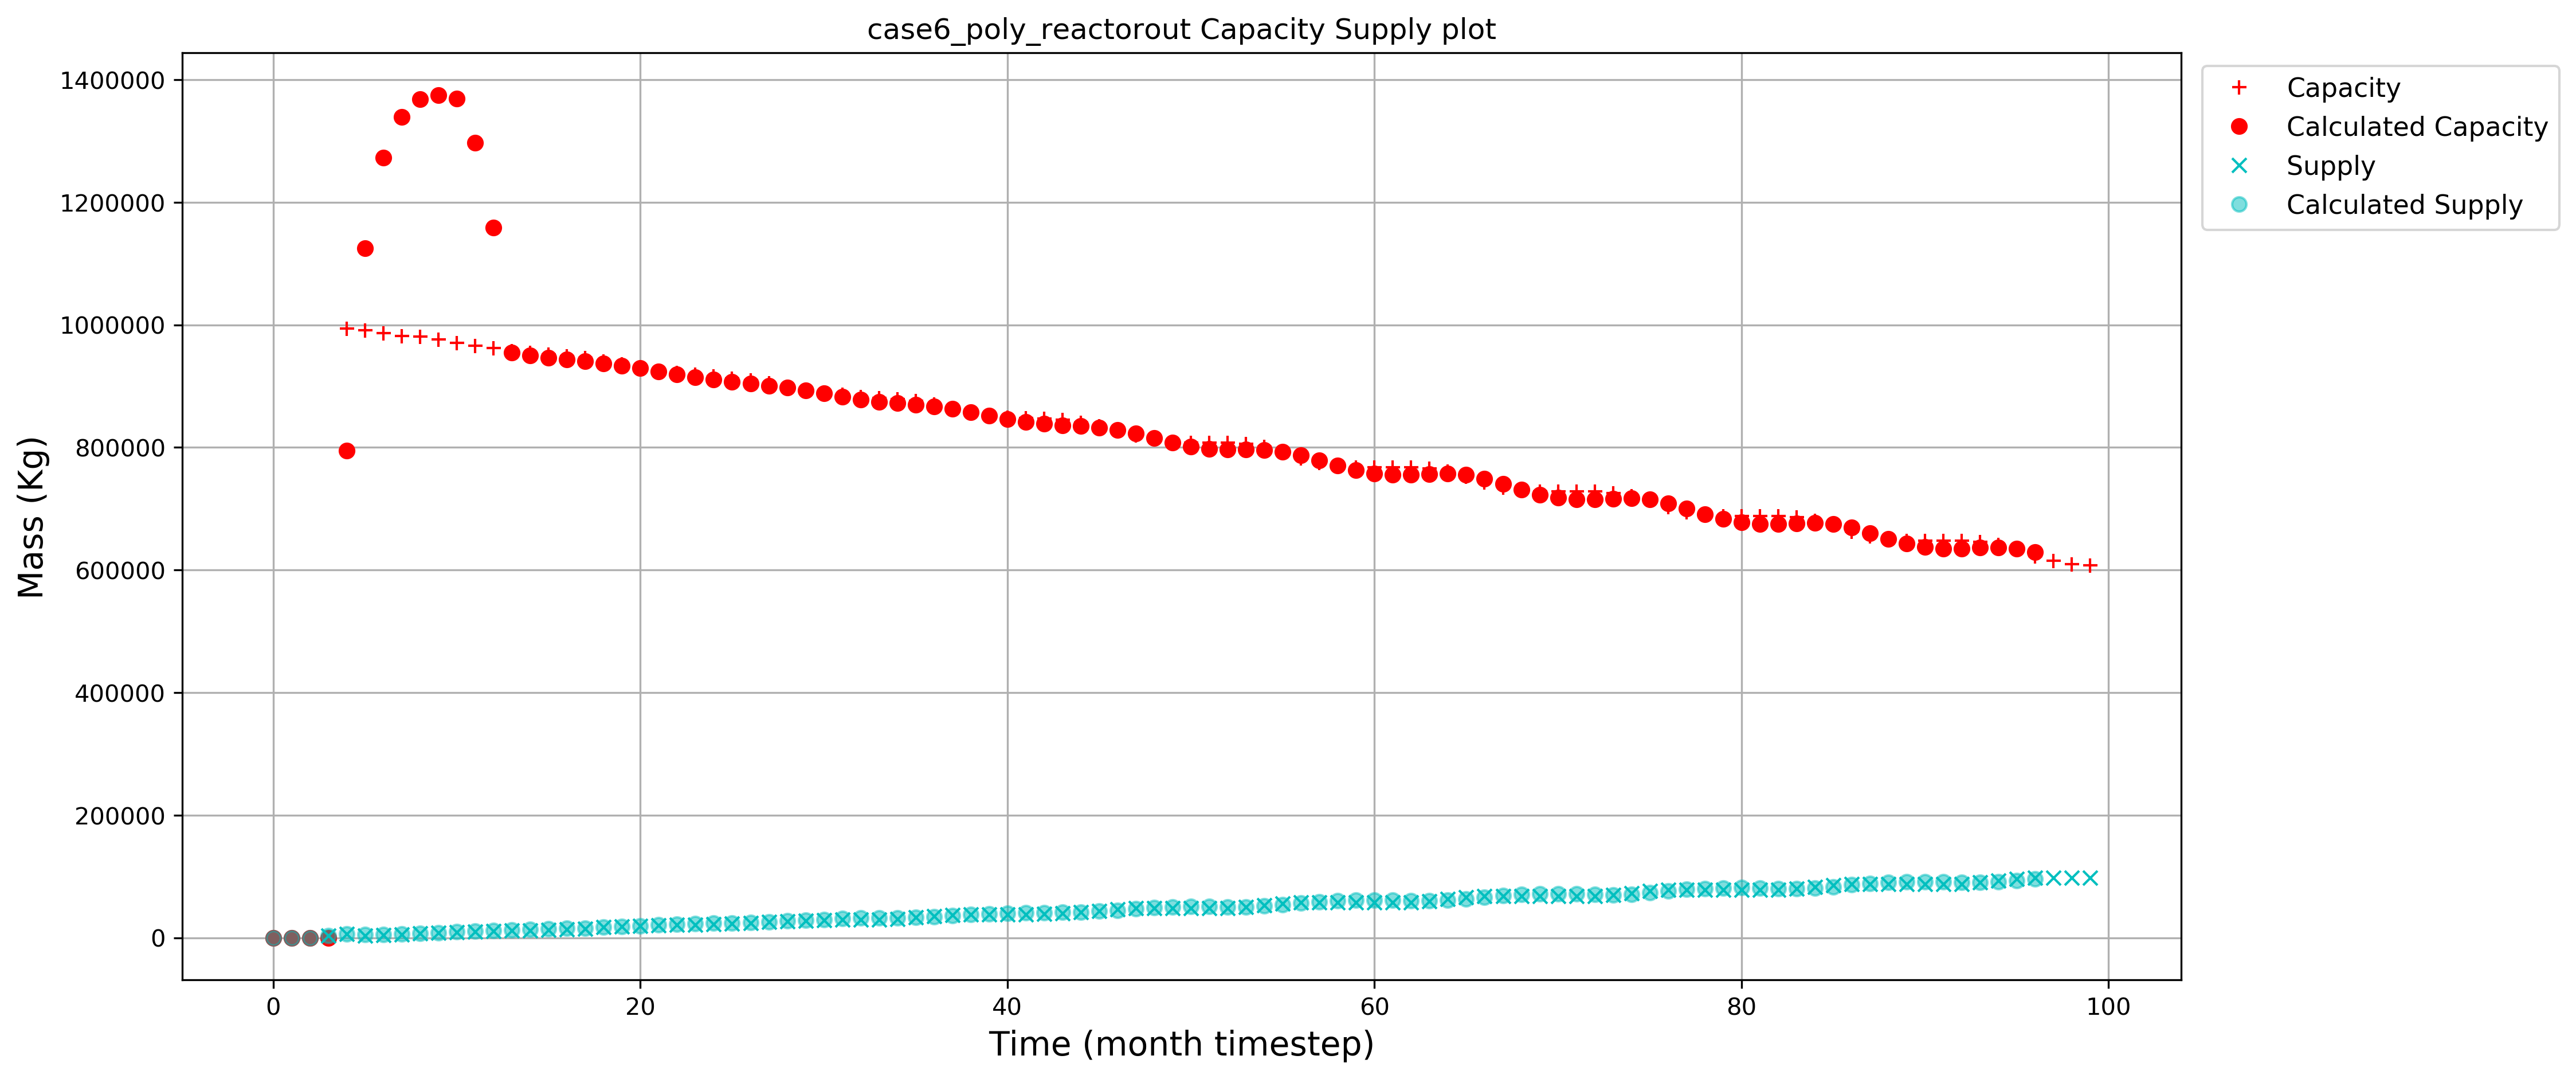

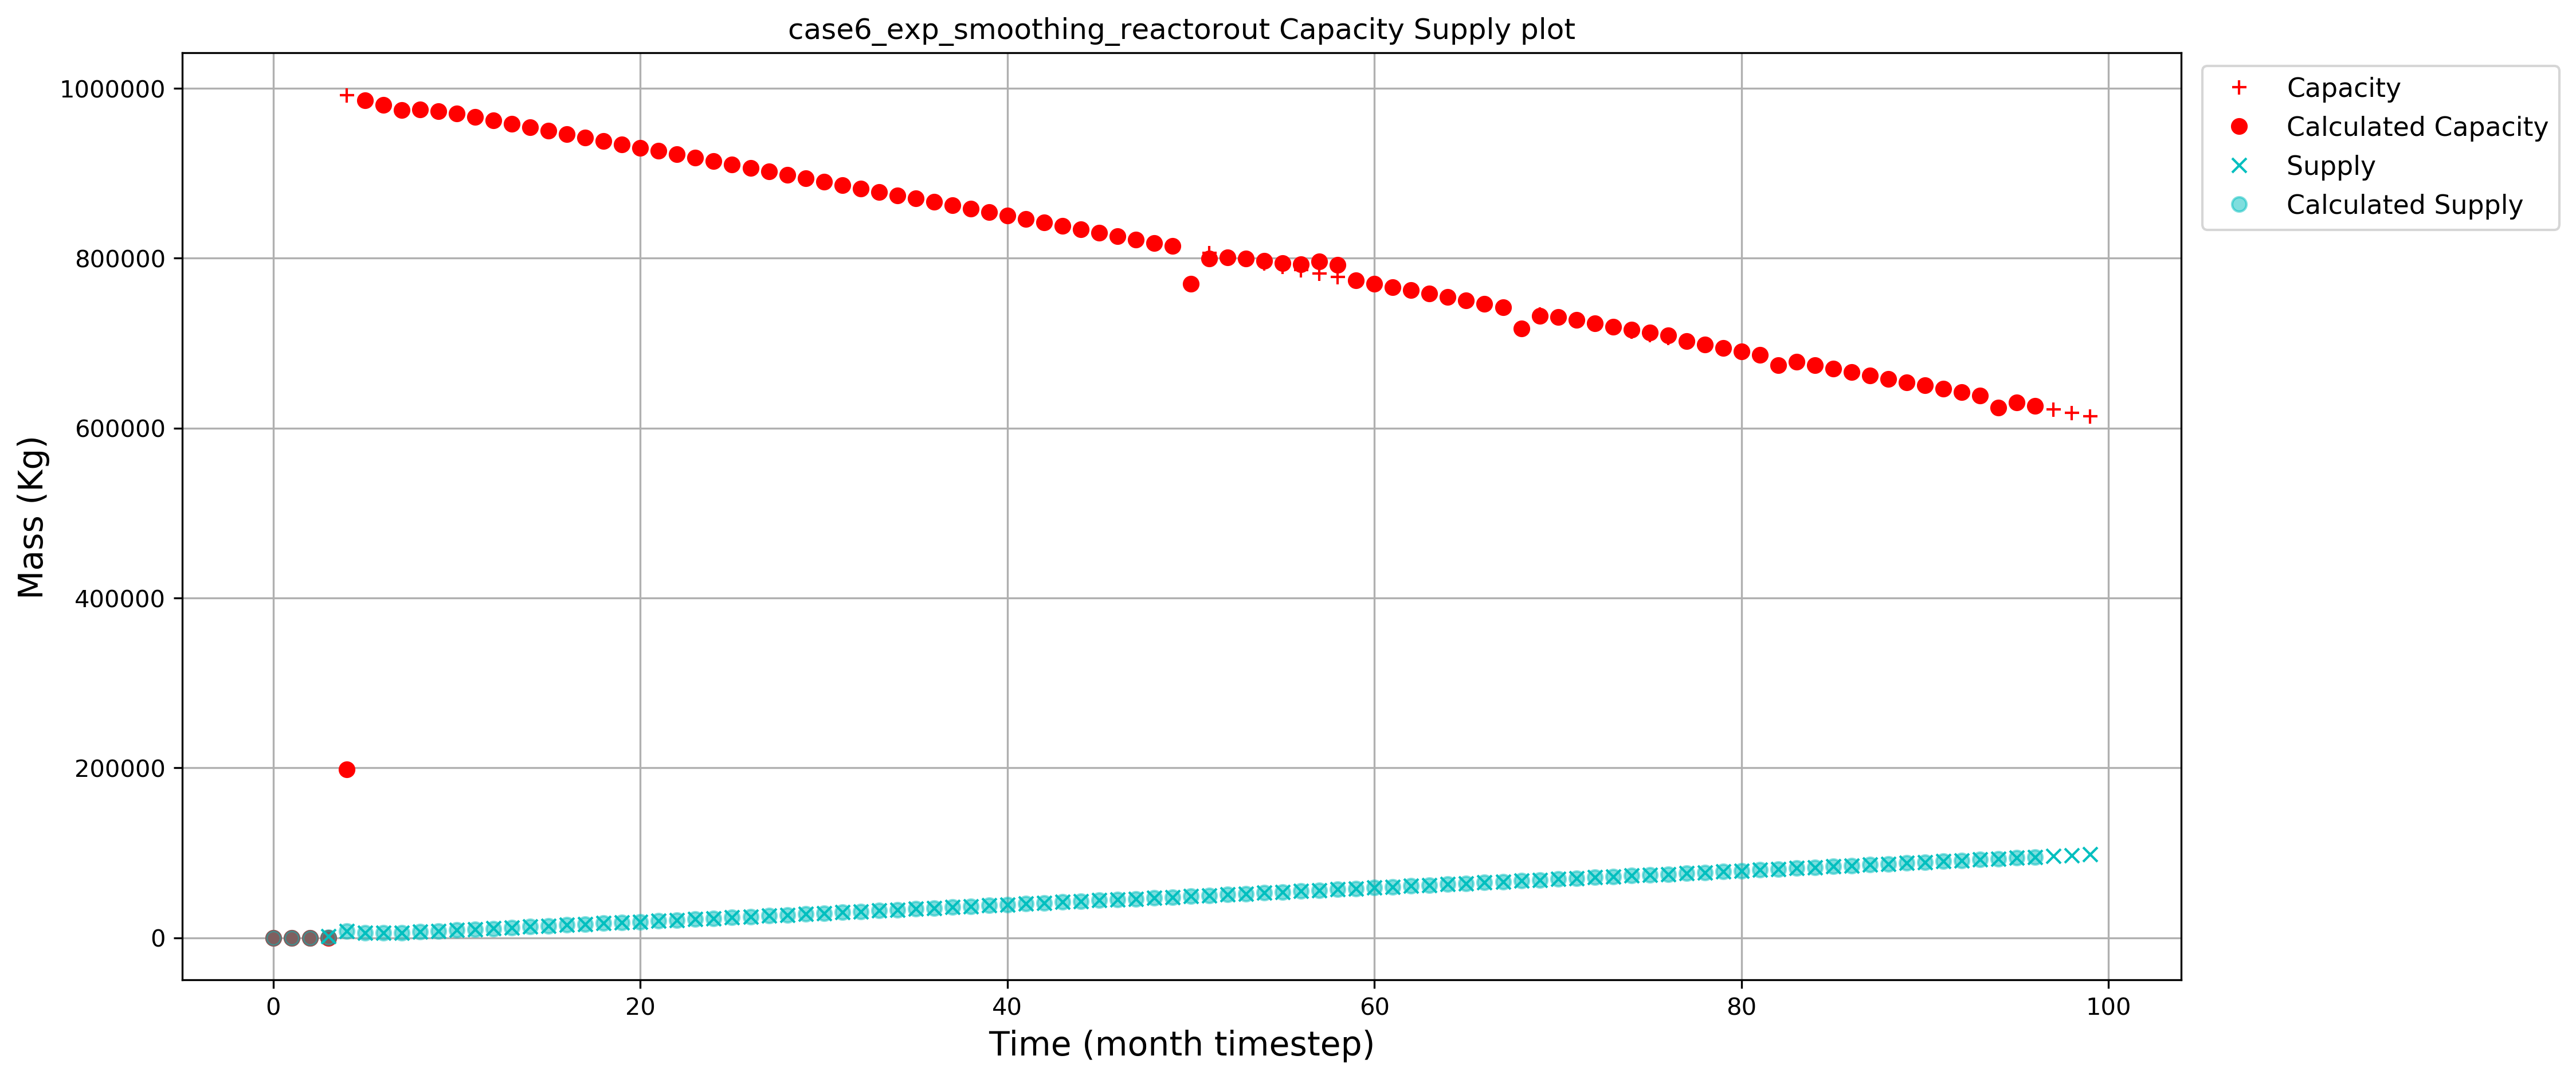

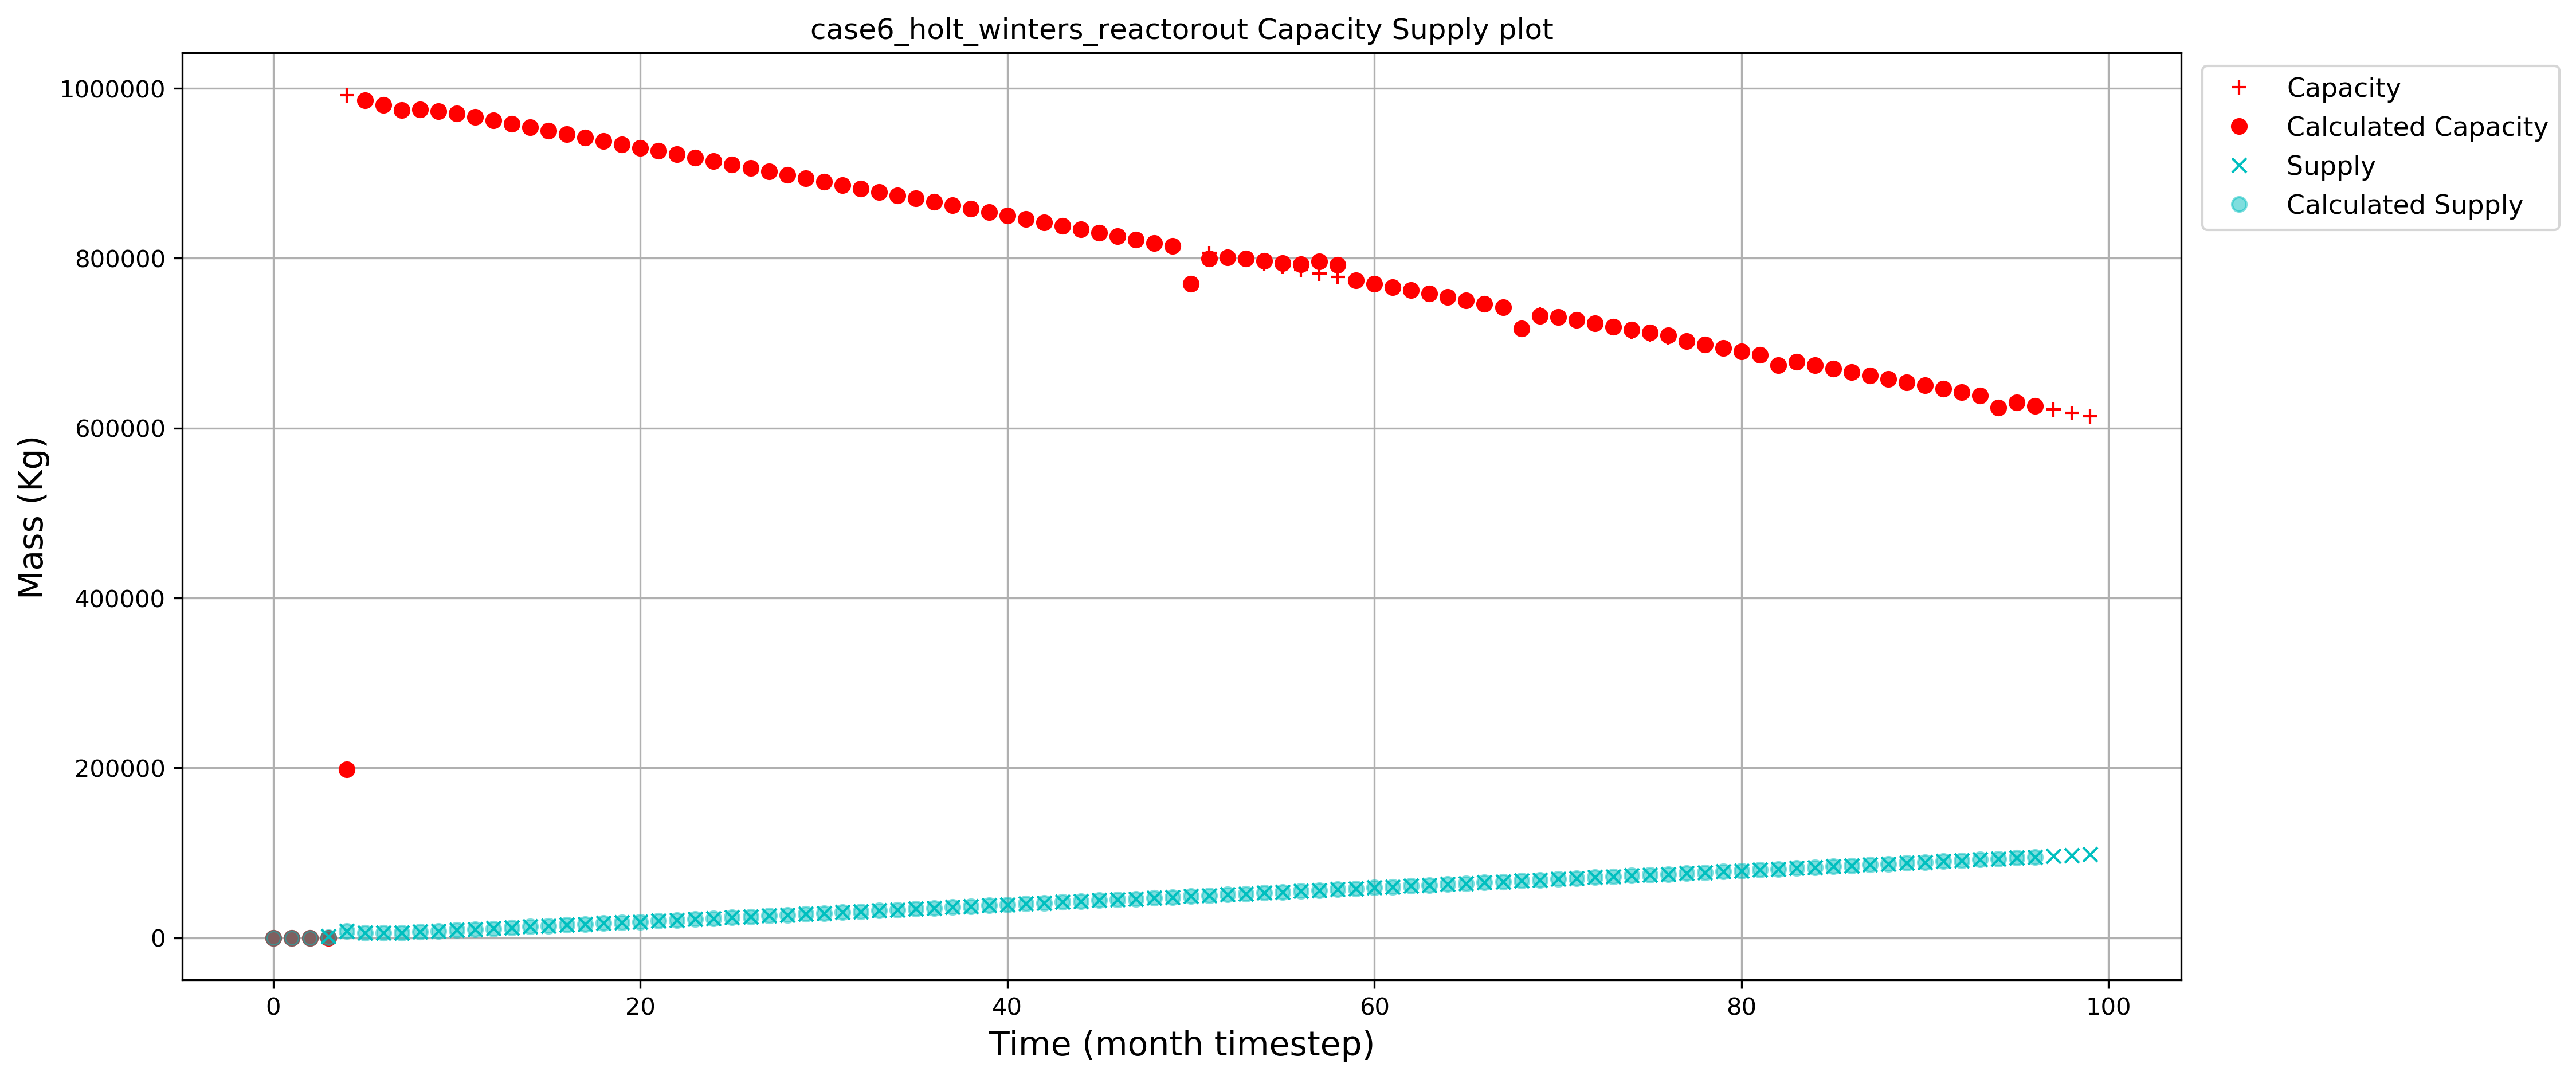

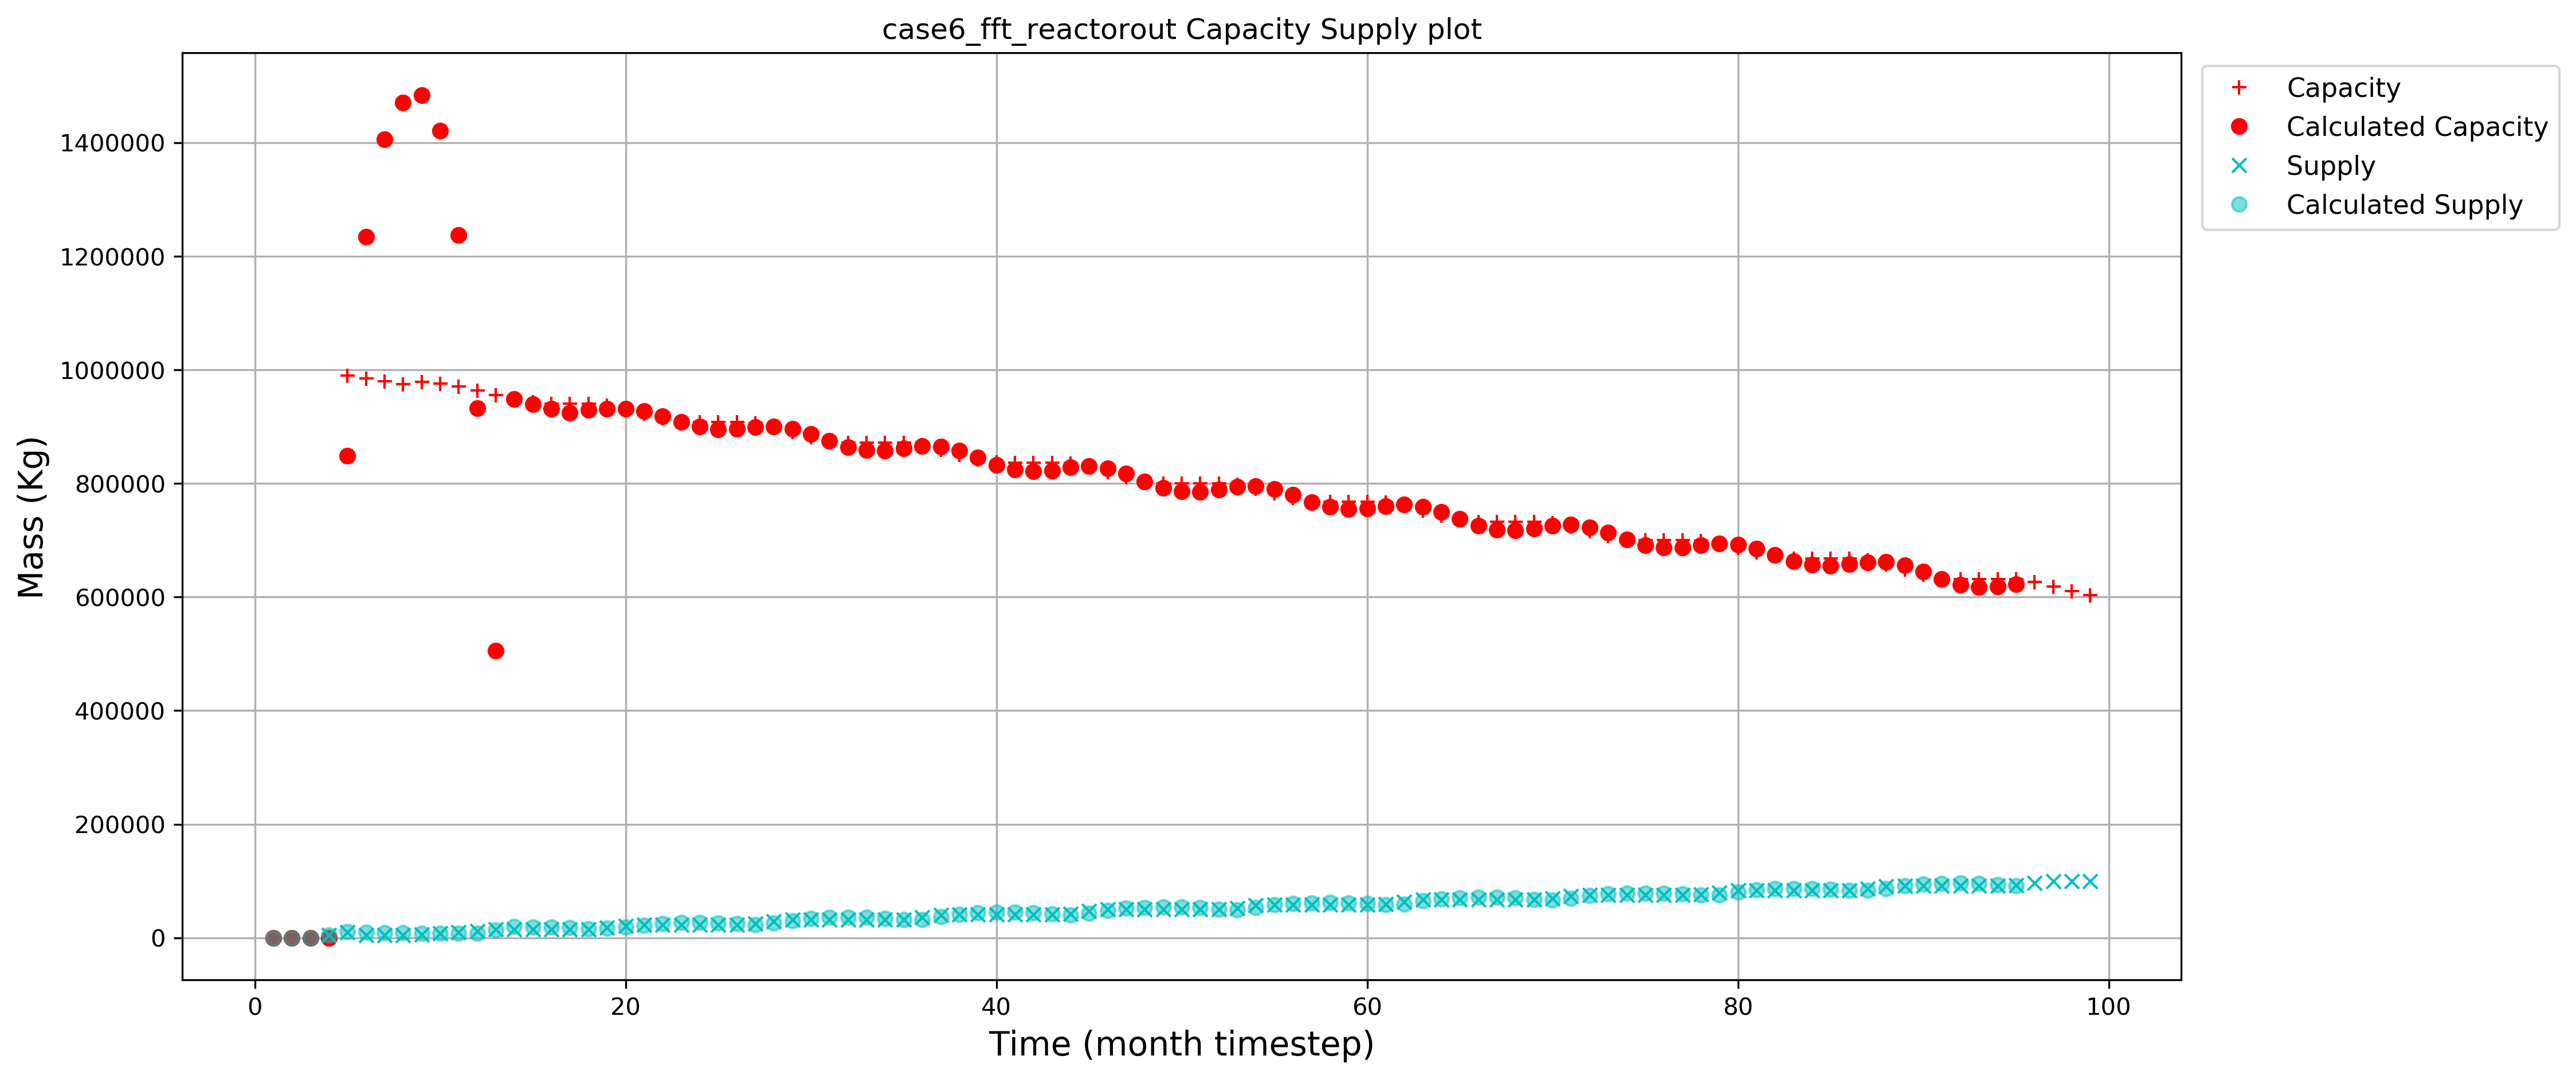

In [3]:
from IPython.display import Image
from IPython.display import display

#I1 = Image(filename='case6_ma_sourceout.png')
#I2 = Image(filename='case6_arma_sourceout.png')
#I3 = Image(filename='case6_arch_sourceout.png')
#I4 = Image(filename='case6_poly_sourceout.png')
#I5 = Image(filename='case6_exp_smoothing_sourceout.png')
#I6 = Image(filename='case6_holt_winters_sourceout.png')
#I7 = Image(filename='case6_fft_sourceout.png')

I8 = Image(filename='case6_ma_power.png')
I9 = Image(filename='case6_arma_power.png')
I10 = Image(filename='case6_arch_power.png')
I11 = Image(filename='case6_poly_power.png')
I12 = Image(filename='case6_exp_smoothing_power.png')
I13 = Image(filename='case6_holt_winters_power.png')
I14 = Image(filename='case6_fft_power.png')
I15 = Image(filename='case6_ma_reactorout.png')
I16 = Image(filename='case6_arma_reactorout.png')
I17 = Image(filename='case6_arch_reactorout.png')
I18 = Image(filename='case6_poly_reactorout.png')
I19 = Image(filename='case6_exp_smoothing_reactorout.png')
I20 = Image(filename='case6_holt_winters_reactorout.png')
I21 = Image(filename='case6_fft_reactorout.png')
display(I8,I9,I10,I11,I12,I13,I14,I15,I16,I17,I18,I19,I20,I21)
#display(I8,I9,I15,I16)
